In [ ]:
cd '.\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\PHREEQC\PHREEQC data processing\'
cd '.\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\PHREEQC\PHREEQC\'

The singular script for creating, executing, and processing PHREEQC simulations will be composed. The script will utilize the batch reactor of PHREEQC, in lieu of the interactive software of PHREEQC. The script and the associated GUI will be packaged within an executable file for user accessability.

# Draft 2

In [68]:
# import libraries
from matplotlib import pyplot 
from to_precision import auto_notation
from scipy.constants import nano, kilo, milli, centi, liter, day, hour
from itertools import chain
from chempy.properties.water_density_tanaka_2001 import water_density
import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
from pubchempy import get_compounds 
from chemicals import periodic_table
import subprocess
import datetime
import pandas
from math import pi, exp, ceil
from glob import glob
import time
import json
import os
import re

# calculation constants
simulated_time_over_computational_time = 9.29    


class ROSSPkg():
    def __init__(self):       
        # establish the general organization structures
        self.parameters = {}
        self.variables = {}
        self.results = {}
        self.results['figures'] = {}

        
    def define_general(self, operating_system, phreeqc_path, database_selection, simulation_type, simulation_title):
        '''Establish general conditions'''
        self.parameters['water_mw'] = float(get_compounds('water', 'name')[0].molecular_weight)
        self.parameters['water_grams_per_liter'] = water_density()
        
        # parameterize the input file
        self.parameters['os'] =  operating_system
        self.parameters['phreeqc_path'] = phreeqc_path
        self.parameters['simulation_type'] = simulation_type
        database_path = f'databases/{database_selection}.json'
        
        title_line = 'TITLE\t %s' %(simulation_title)
        if operating_system == 'Windows':
            database_line = 'DATABASE %s' %(database_path)
            self.results['general_conditions'] = [database_line, title_line]
        else:
            self.results['general_conditions'] = [title_line]
            
        # establish the database content
        self.parameters['database_selection'] = database_selection 
        database = json.load(open(database_path, 'r'))
        self.elements = database['elements']
        self.minerals = database['minerals']

    def transport(self, simulation_time, module_selection = 'BW30-400', module_characteristics = {}, quantity_of_modules = 1, cells_per_module = 12, domain = 'dual', output_perspective = 'scaling', parameterized_timestep = None, kinematic_flow_velocity = None):
        '''Define the TRANSPORT block'''
        # parameterize the module 
        if module_selection == 'BW30-400':
            self.parameters['module_diameter_mm'] =  201                 
            self.parameters['permeate_tube_diameter_mm'] =  29            
            self.parameters['module_length_m'] =  1.016                 
            self.parameters['permeate_flow_m3_per_day'] = 40                  
            self.parameters['max_feed_flow_m3_per_hour'] = 15.9                  
            self.parameters['membrane_thickness_mm'] = 250 * (nano / milli)   
            self.parameters['feed_thickness_mm'] = 0.8636
            self.parameters['active_m_squared'] = 37
            self.parameters['permeate_thickness_mm'] = 0.3               
            self.parameters['polysulfonic_layer_thickness_mm'] = 0.05     
            self.parameters['support_layer_thickness_mm'] = 0.15           
            self.parameters['repeated_membrane_winding_mm'] = 2 * self.parameters['membrane_thickness_mm'] + self.parameters['feed_thickness_mm'] + self.parameters['permeate_thickness_mm'] + 2 * self.parameters['polysulfonic_layer_thickness_mm'] + 2 * self.parameters['support_layer_thickness_mm']     
            print('\nMembrane thickness:', '%s (mm)' %(self.parameters['repeated_membrane_winding_mm']))

        elif module_selection == 'Custom':
            self.parameters['module_diameter_mm'] = module_characteristics['diameter']                          
            self.parameters['permeate_tube_diameter_mm'] = module_characteristics['permeate_diameter']        
            self.parameters['module_length_m'] = module_characteristics['length']                               
            self.parameters['permeate_flow_m3_per_day'] = module_characteristics['permeate_flow']                       
            self.parameters['max_feed_flow_m3_per_hour'] = module_characteristics['feed_flow']                         
            self.parameters['membrane_thickness_mm'] = module_characteristics['membrane_thickness']              
            self.parameters['feed_thickness_mm'] = module_characteristics['feed_spacer_thickness']
            self.parameters['active_m_squared'] = module_characteristics['active_m_squared']
            self.parameters['permeate_thickness_mm'] = input('- What is the permeate spacer thickness? (mm) __ ')
            self.parameters['polysulfonic_layer_thickness_mm'] = module_characteristics['polysulfonic_thickness']
            self.parameters['support_layer_thickness_mm'] = module_characteristics['support_thickness']
            self.parameters['repeated_membrane_winding_mm'] = 2 * self.parameters['membrane_thickness_mm'] + self.parameters['feed_thickness_mm'] + self.parameters['permeate_thickness_mm'] + 2 * self.parameters['polysulfonic_layer_thickness_mm'] + 2 * self.parameters['support_layer_thickness_mm']
            print('\nMembrane thickness:', '%s (mm)' %(self.parameters['repeated_membrane_winding_mm']))

        self.parameters['quantity_of_modules'] = quantity_of_modules
        self.parameters['cells_per_module'] = cells_per_module
        self.variables['cell_meters'] = self.parameters['module_length_m'] / self.parameters['cells_per_module']    
        
        # estimate the feed area       
        self.parameters['active_m_squared_cell'] = self.parameters['active_m_squared'] / self.parameters['cells_per_module']

        # calculate module properties
        module_cross_sectional_area = self.parameters['module_diameter_mm']**2 * pi / 4        #squared millimeters
        permeate_tube_cross_sectional_area = self.parameters['permeate_tube_diameter_mm']**2 * pi / 4     #squared millimeters
#             filtering_layer_thicknes = (self.parameters['module_diameter_mm'] - self.parameters['permeate_thickness_mm']) / 2         #millimeters
        filtration_cross_sectional_area = module_cross_sectional_area - permeate_tube_cross_sectional_area        #squared millimeters
        feed_cross_sectional_area = (self.parameters['feed_thickness_mm'] / self.parameters['repeated_membrane_winding_mm']) * filtration_cross_sectional_area     #squared millimeters
        self.variables['feed_cubic_meters'] = feed_cross_sectional_area * self.parameters['module_length_m'] * milli**2   
        self.variables['feed_kg'] = self.variables['feed_cubic_meters'] / liter * self.parameters['water_grams_per_liter'] * milli    
        self.variables['feed_moles'] = self.variables['feed_kg'] * kilo / self.parameters['water_mw'] 

        # calculate fluid flow characteristics
        if not kinematic_flow_velocity:
            kinematic_flow_velocity = 9.33E-7    #square meters / second
        feed_velocity = self.parameters['max_feed_flow_m3_per_hour'] / (feed_cross_sectional_area * milli**2) / hour     #meters / second
        reynolds_number = feed_velocity * (self.parameters['module_diameter_mm'] - self.parameters['permeate_tube_diameter_mm']) * milli**2 / kinematic_flow_velocity
        self.variables['Reynold\'s number'] = reynolds_number

        # calculate module cell characteristics
        self.variables['feed_kg_cell'] = self.variables['feed_kg'] / self.parameters['cells_per_module']   
        self.variables['feed_moles_cell'] = self.variables['feed_moles'] / self.parameters['cells_per_module']   

        # calculate simulation timestep that adheres to the Courant condition   
        timestep = self.parameters['module_length_m'] / feed_velocity  # seconds
        if parameterized_timestep:
            timestep = parameterized_timestep
            
        courant_timestep = self.variables['cell_meters'] / feed_velocity
        if timestep < courant_timestep:
            timestep = courant_timestep
            
        # print simulation parameters
        print('cell length (m): ', self.variables['cell_meters'])
        print('feed velocity (m/s): ', feed_velocity) 
        print('feed_cross_sectional_area (mm^2): ', feed_cross_sectional_area)

            
        self.parameters['permeate_moles_per_cell'] = (self.parameters['permeate_flow_m3_per_day'] / day / liter * self.parameters['water_grams_per_liter'] / self.parameters['water_mw']) * (timestep / self.parameters['cells_per_module'])      #moles / (cell * timestep)
        print('permeate_removal_per_cell', self.parameters['permeate_moles_per_cell'])

        # define the transport black
        transport_line = '\nTRANSPORT'
        cells_line = '-cells\t\t\t%s' %(self.parameters['cells_per_module'])
        
        self.simulation_shifts = ceil(simulation_time / timestep) #(self.parameters['cells_per_module']*self.parameters['quantity_of_modules'])
        shifts_line = '-shifts\t\t\t%s' %(self.simulation_shifts)
        lengths_line = '-lengths\t\t%s' %(self.variables['cell_meters'])
        timestep_line = '-time_step\t\t%s\t# the Courant condition is satisfied with the cell_length of %s m and the feed velocity of %s m/s' %(timestep, self.variables['cell_meters'], feed_velocity)
        initial_time_line = '-initial_time\t\t0'    
        boundary_conditions_line = '-boundary_conditions\tconstant\tconstant \t # Dirichlet boundary condition'
        
        if domain == 'single':
            domain_line = '-stagnant\t\t0\t\t0\t\t\t0\t\t0 \t # single domain\n#\t\t\t^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'
        elif domain == 'dual':
            domain_line = '-stagnant\t\t1\t\t1\t\t\t0.1\t\t0.9 \t # dual domain\n#\t\t\t^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'

        self.parameters['output_perspective'] = output_perspective
        if self.parameters['output_perspective'] == 'scaling':
            punch_cells_line = '-punch_cells\t\t1-%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t%s' %(self.simulation_shifts)
        elif self.parameters['output_perspective'] == 'brine':
            punch_cells_line = '-punch_cells\t\t%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t1'       

        # create the transport block
        self.results['transport_block'] = []
        self.results['transport_block'].extend((transport_line, cells_line, shifts_line, lengths_line, timestep_line, initial_time_line, boundary_conditions_line, domain_line, punch_cells_line, punch_frequency_line))


    def reaction(self, permeate_approach = 'linear_permeate', permeate_efficiency = 1, head_loss = -0.15, final_cf = 2):
        '''Define the REACTION block'''
        self.parameters['permeate_approach'] = permeate_approach
        cfs = []
        cell_moles = []
        reaction_parameters = []
        iteration = 0
        cumulative_cf = 1 
        self.results['reaction_block'] = []
        for module in range(self.parameters['quantity_of_modules']):
            module_previous_moles_removed = 0
            if permeate_approach == 'linear_permeate':
                if iteration == 0:
                    moles = self.variables['feed_moles']

                initial_moles_removed = self.parameters['permeate_moles_per_cell'] * 2 / (1 + exp(head_loss))
                final_moles_removed = initial_moles_removed * exp(head_loss)
                try:
                    removed_moles_slope = ((final_moles_removed - initial_moles_removed) / (self.parameters['cells_per_module'])) / permeate_efficiency
                except:
                    removed_moles_slope = 0
                average_moles_removed = (final_moles_removed + initial_moles_removed) / 2
                print('(Removed moles / cell) slope: ', removed_moles_slope)

                for cell in range(self.parameters['cells_per_module']):
                    removed_moles_in_cell = (cell * removed_moles_slope + initial_moles_removed)
                    reaction_parameters.append(removed_moles_in_cell)
                    module_previous_moles_removed += removed_moles_in_cell
                    
                cf = moles / (moles - module_previous_moles_removed)
                cumulative_cf *= cf

                moles -= module_previous_moles_removed
                iteration += 1
                print('moles', moles)
                print('module_previous_moles_removed', module_previous_moles_removed)

            if permeate_approach == 'linear_cf':
                module_iteration = 0
                initial_cf = 1

                cf_slope = (final_cf - initial_cf) / self.parameters['cells_per_module']
                for cell in range(self.parameters['cells_per_module']):
                    cell_cf = (cell+1) * cf_slope + initial_cf
                    cfs.append(cell_cf)    

                for cf in cfs:
                    moles_to_be_removed =  self.parameters['feed_moles_cell'] - (self.parameters['feed_moles_cell'] / cf)
                    if module_iteration == 0:
                        moles = self.variables['feed_moles']
                        reaction_parameters.append(moles_to_be_removed)
                    if module_iteration > 0:
                        module_previous_moles_removed += reaction_parameters[-1] 
                        reaction_parameter = moles_to_be_removed - module_previous_moles_removed
                        reaction_parameters.append(reaction_parameter)
                        moles -= moles_to_be_removed

                    module_iteration += 1

                cf = cfs[-1]
                cumulative_cf *= cf
                moles = self.parameters['feed_moles'] - moles_to_be_removed   # moles_to_be_removed = the final quantity of moles is calculated with naming from the linear permeate flux method to be consistent  

            if self.parameters['simulation_type'] == 'transport':
                self.results['reaction_block'].append('\n')
                for cell in range(self.parameters['cells_per_module']):
                    cell_number = (cell) + self.parameters['cells_per_module'] * module
                    reaction_line = 'REACTION %s' %(cell_number)
                    
                    if (cell+1) < self.parameters['cells_per_module']:
                        reaction_line += f'\n\tH2O -1; {reaction_parameters[cell_number]}' 
                    elif (cell+1) == self.parameters['cells_per_module']:
                        reaction_line += f'''\n\tH2O -1; {reaction_parameters[cell_number]}
        INCREMENTAL_REACTIONS \ttrue'''     

                    self.results['reaction_block'].append(reaction_line)

            elif self.parameters['simulation_type'] == 'evaporation':
                parameter_quantity = 15                          
                recursive_assymtote_multiplier = 1.335449219     # ??? arbitrary assignment of kg of water in the simulation?
                total_moles_removed = sum(reaction_parameters)
                initial_evaporation_parameter = total_moles_removed / recursive_assymptote_multiplier
                evaporation_reaction_parameters = ['0', initial_evaporation_parameter]  # ???
                for parameter in range(1, parameter_quantity):
                    evaporation_reaction_parameter = evaporation_reaction_parameters[parameter] * 1/4
                    evaporation_reaction_parameters.append(evaporation_reaction_parameter)

                # define the reaction block
                reaction_line = 'REACTION 1'
                reaction_line += '\n\tH2O -1; '
                reaction_line += ' '.join(evaporation_reaction_parameters) 
                self.parameters['reaction_block'] = [reaction_line]

            # the calculated reaction parameters will be added and printed to a generated PHREEQC input file
            final_solution_mass = moles * self.parameters['water_mw'] * milli  #kg water mass
            final_cf_cell = self.variables['feed_kg'] / final_solution_mass
            print('Effluent module %s CF:' %(module + 1), final_cf_cell)

            if self.parameters['os'] == 'windows':
                self.results['reaction_block'].append('#%s' %(permeate_approach))
                if permeate_approach == 'linear permeate':
                    self.results['reaction_block'].append('''
        #Permeate efficiency parameter: %s
        #Head loss parameter: %s''' %(permeate_efficiency, head_loss))
                self.results['reaction_block'].append('''    #Effluent module %s:
        #Estimated CF: %s
        #Estimated solution mass: %s\n\n''' %(module + 1, cumulative_cf, final_solution_mass))


    def solutions(self, water_selection, custom_water_parameters = {}, solution_description = '', parameterized_alkalinity = False, parameterized_ph_charge = True):
        """Specify the SOLUTION block of the simulation."""
        # create the solution line of the input file
        self.results['solution_block'] = []
        
        self.parameters['water_selection'] = water_selection

        if self.parameters['simulation_type'] == 'transport':
            initial_solution_line = '\nSOLUTION 0\t%s' % (solution_description)
        elif self.parameters['simulation_type'] == 'evaporation':
            initial_solution_line = '\nSOLUTION 1\t%s' % (solution_description)
        self.results['solution_block'].append(initial_solution_line)

        #=============================================================================
        # determine which predefined solution should be simulated

        if water_selection is not None:       
            # import the predefined water body
            water_file_path = f'./water_bodies/{water_selection}.json'
            water_body = json.load(open(water_file_path))
            
            elements_lines = []
            for content, information in water_body.items():
                if content == 'element':
                    for element, information2 in information.items():
                        if element in self.elements:
                            conc = information2['concentration (ppm)']
                            ref = information2['reference']
                            if len(str(conc)) <= 3:
                                elements_lines.append(f'{element}\t\t{conc}\t#{ref}')
                            else:
                                elements_lines.append(f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database')
                                
                elif content == 'temperature':
                    temperature = information['celcius']
                    temperature_reference = information['reference']
                elif content == 'pe':
                    pe = information['value']
                    pe_reference = information['reference']
                elif content == 'Alkalinity':
                    alkalinity = information['value']
                    alkalinity_reference = information['reference'] 
                elif content == 'pH':
                    ph = information['value']
                    ph_reference = information['reference']

        if custom_water_parameters != {}:
            for content, information in custom_water_parameters.items():
                
                if content == 'element':
                    for element, information2 in information.items():
                        conc = information2['concentration (ppm)']
                        ref = information2['reference']
                        if element in self.elements:                          
                            if len(str(conc)) <= 3:
                                elements_lines[element] = (f'{element}\t\t{conc}\t#{ref}')
                            else:
                                elements_lines[element] = (f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database'.format(element, self.parameters['database_selection']))
                                    
                            
                # create the temperature line of the input file
                elif content == 'temperature':                    
                    temperature = custom_water_parameters['temperature']['value']
                    temperature_reference = custom_water_parameters['temperature']['reference']

                elif content == 'pe':       
                    pe = custom_water_parameters['pe']['value']
                    pe_reference = custom_water_parameters['pe']['reference']

                elif content == 'Alkalinity':
                    alkalinity = custom_water_parameters['Alkalinity']['value']
                    alkalinity_reference = custom_water_parameters['Alkalinity']['reference'] 

                elif content == 'pH':
                    ph = custom_water_parameters['ph']['value']
                    ph_reference = custom_water_parameters['ph']['reference']
                    
                    
        # parameterize the lines of the SOLUTIONS block
        temperature_line = f'temp \t {temperature} \t #{temperature_reference}.'

        if parameterized_ph_charge and not parameterized_alkalinity:
            ph_line = f'pH \t\t {ph} charge #{ph_reference}'
            alkalinity_line = ''
        elif parameterized_alkalinity and not parameterized_ph_charge:
            ph_line = f'pH \t\t {ph} #{ph_reference}'
            alkalinity_line = f'Alkalinity \t {alkalinity} #{alkalinity_reference}'
        else:
            print('ERROR: The pH charge balance cannot execute when the alkalinity is defined.')
            
        pe_line = f'pe \t\t {pe} \t   #{pe_reference} // 4.00 is the default (?)'            
        unit_line = 'units \t ppm' 
        elements_line = '\n'.join(elements_lines)
        water_mass = self.variables['feed_kg']
        if water_selection == 'Bakken formation':
            water_line = f'-water \t{water_mass}\t#TDS=300 ppthousand [before fudging]' 
        elif water_selection == 'German Basin':
            water_line = f'-water \t{water_mass}\t#TDS=314 ppthousand [before fudging]'
        else:
            water_line = f'-water \t{water_mass}'

        self.results['solution_block'].extend([temperature_line, ph_line, pe_line, alkalinity_line, unit_line, elements_line, water_line])

        #parameterize the initial module solution
        if self.parameters['simulation_type'] == 'transport':
            total_cells = self.parameters['cells_per_module'] * self.parameters['quantity_of_modules']
            feed_solution_line = f'\nSOLUTION 1-{total_cells}\tInitial solution in the RO module'
            self.results['solution_block'].extend([feed_solution_line,'temp \t 25','units \t ppm'])

            for element in self.elements:
                element_concentration = 0
                element_line = f'{element}\t{element_concentration}'    
                self.results['solution_block'].append(element_line)

            water_line = '-water \t %s' %(water_mass)
            self.results['solution_block'].append(water_line)


    def equilibrium_phases(self, block_comment = '', ignored_minerals = [], existing_parameters = {}, verbose = True):
        """Specify the EQUILIBRIUM_PHASES block of the simulation."""
        # define mineral sizes for later spacing
        short_mineral_names = ['Barite', 'Gypsum','Halite', 'Natron', 'Quartz', 'Talc','Trona', 'Borax', 'Albite', 'K-mica','Illite', 'Pyrite', 'Sulfur',]
        long_mineral_names = ['Anthophyllite', 'Hexahydrite', 'Leonhardite', 'Nesquehonite', 'Pentahydrite', 'Portlandite','Sepiolite(d)', 'Boric_acid,s', 'K2B4O7:4H2O', 'NaB5O8:5H2O', 'Rhodochrosite', 'Strontianite','Hydroxyapatite', 'Chlorite(14A)', 'Mackinawite', 'Hausmannite', 'Pyrochroite']
        
        # determine the set of possible minerals 
        elements_list = list(self.elements)
        compounds_list = [self.elements[x]['gfw_formula'] for x in elements_list]
        total_accepted_characters = list(chain(compounds_list, elements_list))

        self.variables['described_minerals'] = {}
        for mineral in self.minerals:
            mineral_formula = self.minerals[mineral]['formula']
            original_formula = mineral_formula
            
            # remove entities is an ordered fashion
            mineral_formula = re.sub('(SO4|H2O|OH|CO3)', '', mineral_formula)
            mineral_formula = re.sub('([0-9()•:.])', '', mineral_formula)
            mineral_elements = re.findall('[A-Z][a-z]?', mineral_formula)
            
            for element in mineral_elements:
                if element in elements_list:
                    mineral_formula = re.sub(element, '', mineral_formula)
            if mineral_formula == '':
                self.variables['described_minerals'][mineral] = {'formula': original_formula}
            else:
                if verbose:
                    print(f'--> < {mineral_formula} > characters of < {mineral} >, formula = < {original_formula} > , are undescribed by the parameterized elements.')
                        
        # define the equilibrium_phases block
        self.results['equilibrium_phases_block'] = []
        if self.parameters['simulation_type'] == 'transport':
            equilibrium_phases_number = '1-{}'.format(self.simulation_shifts)
        elif self.parameters['simulation_type'] == 'evaporation':
            equilibrium_phases_number = '1'
            
        equilibrium_phases_line = f'\nEQUILIBRIUM_PHASES {equilibrium_phases_number}\t{block_comment}'
        self.results['equilibrium_phases_block'].append(equilibrium_phases_line)

        # define the equilibrium_phases lines for the code block
        for possible_mineral in self.variables['described_minerals']:
            if possible_mineral not in ignored_minerals:
                if possible_mineral in short_mineral_names:
                    mineral_line = f'{possible_mineral}\t\t' 
                elif possible_mineral == 'Ca-Montmorillonite':
                    mineral_line = f'{possible_mineral}'
                else:
                    mineral_line = f'{possible_mineral}\t'

                if possible_mineral in existing_parameters:
                    for key, value in existing_parameters[possible_mineral].items():
                        if key == 'saturation':
                            mineral_saturation = value['saturation']
                            mineral_line += f'\t{mineral_saturation}'
                        if key == 'initial_moles':
                            initial_moles = value['initial_moles']
                            mineral_line += f'\t{initial_moles}'
                else:
                    mineral_line += f'\t0\t0'
                    
                self.results['equilibrium_phases_block'].append(mineral_line)        

    def selected_output(self, output_filename = None):
        '''Specify the output file after a PHREEQC simulation'''
        # create parameter lines 
        if output_filename is None:
            count = 0
            selected_output_file_name = '_'.join([str(x) for x in [datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count]]) 
            while os.path.exists(f'{selected_output_file_name}.txt'):
                count += 1
                selected_output_file_name = '_'.join([str(x) for x in [datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count]]) 
        else:
            selected_output_file_name = output_filename

        selected_output_file_name += '.txt'
        self.parameters['selected_output_file_name'] = selected_output_file_name

        minerals_line = ''
        for mineral in self.minerals:
             minerals_line += f' {mineral}'

        elements_line = ''
        for element in self.elements:
             elements_line += f' {element}'

        # define parameter lines
        first_line = '\nSELECTED_OUTPUT'
        file_name_line = f'-file\t\t\t{selected_output_file_name}'
        reaction_line = '-reaction\t\ttrue'
        temperature_line = '-temperature\t\ttrue'
        total_elements_line = '-totals\t\t\t' + elements_line    
        saturation_indices_line = f'-saturation_indices\t{minerals_line}'
        equilibrium_phases_line = f'-equilibrium_phases\t{minerals_line}'
        ph_line = '-pH\t\t\ttrue'
        solution_line = '-solution'
        time_line = '-time\t\t\ttrue'
        distance_line = '-distance\t\ttrue'
        simulation_line = '-simulation\t\ttrue'
        high_precision_line = '-high_precision\ttrue'
        step_line = '-step'
        water_line = '-water'

        # establish the selected_output_block
        self.results['selected_output_block'] = []
        self.results['selected_output_block'].extend((first_line, file_name_line, reaction_line, temperature_line, total_elements_line, saturation_indices_line, equilibrium_phases_line, ph_line, time_line, distance_line, simulation_line, high_precision_line, solution_line, step_line,water_line))


    def export(self, input_path = None, output_path = None, print_block = True):
        """View and export the PHREEQC input file"""
        # define the simulation input path 
        if input_path is None:
            file_number = 0
            if self.parameters['permeate_approach'] == 'linear_permeate':
                permeate_approach_name = 'LinPerm'
            elif self.parameters['permeate_approach'] == 'linear_cf':
                permeate_approach_name = 'LinCF'

            simulation_name = '_'.join([str(x) for x in [datetime.date.today(), 'ROSS', self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'],self.parameters['output_perspective'], permeate_approach_name, file_number]])
            while os.path.exists(simulation_name):
                file_number += 1
                simulation_name = '_'.join([str(x) for x in [datetime.date.today(), 'ROSS', self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'],self.parameters['output_perspective'], permeate_approach_name, file_number]])

            self.parameters['input_file_name'] = 'input.pqi'
            working_directory = os.getcwd()
            self.simulation_path = os.path.join(working_directory, simulation_name)
            os.mkdir(self.simulation_path)
            self.parameters['input_path'] = os.path.join(self.simulation_path, self.parameters['input_file_name'])

        else:
            self.parameters['input_path'] = input_path
            
        # comment the corresponding simulation in the input file
        simulation_line = '# {}'.format(self.simulation_path)
        self.results['solution_block'].insert(0, simulation_line)
        
        self.results['complete_lines'] = chain(self.results['general_conditions'], self.results['solution_block'], self.results['equilibrium_phases_block'], self.results['reaction_block'], self.results['selected_output_block'], self.results['transport_block']) 
            
        # printing and exporting the input file
        with open(self.parameters['input_path'],'w') as input_file:
            for line in self.results['complete_lines']:
                if print_block:
                    print(line)
                input_file.write(line + '\n')
            
        self.input_file = open(self.parameters['input_path'],'r').read()
        
        # define the simulation output path 
        if output_path is None:
#             self.parameters['output_file_name'] = re.sub('(?<=\.)(.+)' , 'pqo', self.parameters['input_file_name']) 
            self.parameters['output_file_name'] = 'output.pqo'
            self.parameters['output_path'] = os.path.join(self.simulation_path, self.parameters['output_file_name'])
        else:
            self.parameters['output_path'] = output_path    
            
        
        # define a table of parameters
        parameters = {'parameter':[], 'value':[]}
        parameters['parameter'].append('simulation')
        parameters['value'].append(self.simulation_path)
        for parameter in self.parameters:
            parameters['parameter'].append(parameter)
            parameters['value'].append(self.parameters[parameter])
        parameters_table = pandas.DataFrame(parameters)
        display(parameters_table)
        
#         parameters_file_name = re.sub('(\..+)' , '_parameters.csv', self.parameters['input_file_name'])   
        parameters_file_name = 'parameters.csv'
        parameters_path = os.path.join(self.simulation_path, parameters_file_name)
        parameters_table.to_csv(parameters_path)
        
        # define a table of variables
        variables = {'variable':[], 'value':[]}
        variables['variable'].append('simulation')
        variables['value'].append(self.simulation_path)
        for variable in self.variables:
            variables['variable'].append(variable)
            variables['value'].append(self.variables[variable])
        variables_table = pandas.DataFrame(variables)
        display(variables_table)
        
#         variables_file_name = re.sub('(\..+)' , '_variables.csv', self.parameters['input_file_name'])   
        variables_file_name = 'variables.csv'
        variables_path = os.path.join(self.simulation_path, variables_file_name)
        variables_table.to_csv(variables_path)

    def execute(self, print_output = True):
        '''Execute a PHREEQC input file '''
        database_path = os.path.join(self.parameters['phreeqc_path'], 'database\\{}.dat'.format(self.parameters['database_selection']))

        def run(input_file, first=False):
            phreeqc = phreeqc_mod.IPhreeqc()                 
            phreeqc.load_database(r"%s" %(database_path))
            phreeqc.run_string(input_file)
            
            # define the conc dictionary
            output = phreeqc.get_selected_output_array()

            header = output[0]
            conc = {}
            for head in header:
                conc[head] = []
            for row in output[1:]:
                for col, head in enumerate(header):
                    conc[head].append(row[col])
                    
            return phreeqc, conc

        def main(input_file, print_output):
            import timeit

            def measure_time(func, *args, **kwargs):
                start = timeit.default_timer()
                phreeqc, conc = func(*args, **kwargs)
                return phreeqc, conc, timeit.default_timer() - start

            phreeqc, conc, run_time = measure_time(run, input_file, print_output)
            
            # export the simulation results
            fobj = open(self.parameters['output_path'], 'w')
            headers = conc.keys()
            if print_output:
                pandas.set_option('display.max_columns', None)
                self.results['csv_data'] = pandas.DataFrame(conc, columns = headers)
                display(self.results['csv_data'])
            fobj.write(self.results['csv_data'].to_string())
            
            self.variables['run_time (s)'] = run_time

        # verify that the PHREEQC executed and generated the appropriate files
        main(self.input_file, print_output)
        
        if os.path.exists(self.parameters['output_path']):
            self.parameters['selected_output_path'] = os.path.join(self.simulation_path, self.parameters['selected_output_file_name'])
            if os.path.exists(self.parameters['selected_output_path']):
                print('The execution is complete.')
            else:
                print('ERROR: The SELECTED_OUTPUT file {} is missing. The simulation failed to simulate.'.format(self.parameters['selected_output_file_name']))
        else:
            print('\nERROR: The simulation failed to execute.')
            

    def process_selected_output(self, selected_output_path = None, graphical_selection = 'scaling', plot_title = '', title_font = 'xx-large', label_font = 'x-large', plot_caption = '', table_title = None, export_figure = True, export_format = 'svg', individual_plots = True):
        """Interpreting the PHREEQC SELECTED_OUTPUT file and conducting the plotting functions"""
        self.parameters['graphical_selection'] = graphical_selection
        
        databases = [database for database in glob('./databases/*.json')]
        databases = [re.search('(\w+)(?=.json)', database).group() for database in databases]

        if 'csv_data' not in self.results:
            # determining the appropriate variables
            if selected_output_path is not None:
                # define the simulation perspective
                self.parameters['output_perspective'] = 'scaling'
                if re.search('(brine)', selected_output_path, flags=re.IGNORECASE):
                    self.parameters['output_perspective'] = 'brine'

                # define the simulation type
                self.parameters['simulation_type'] = 'transport'
                for line in selected_output_path:
                    if re.search('(evaporation)', line, re.IGNORECASE):
                        self.parameters['simulation_type'] = 'evaporation'

                # define the database contents
                self.parameters['database_selection'] = 'llnl'
                for database in databases:
                    names = database.split('_')
                    if all(re.search(name, selected_output_path, re.IGNORECASE) for name in names):
                        self.parameters['database_selection'] = database                   
                        break                    

                database_json = json.load(open('./databases/{}.json'.format(self.parameters['database_selection'])))
                self.minerals = database_json['minerals']
                self.elements = database_json['elements']

                # define the simulation
                self.parameters['selected_output_file_name'] = re.search('(\w+)(?=\.)', selected_output_path).group()

            else:
                working_directory = os.getcwd()
                selected_output_path = os.path.join(working_directory, self.parameters['selected_output_file_name'])                     

            # preparing the SELECTED_OUTPUT file into a dataframe
            selected_output = open(selected_output_path, 'r')
            original_data = pandas.read_table(selected_output, sep = '\t')
            self.results['csv_data'] = pandas.DataFrame(original_data)
            for column in self.results['csv_data'].columns:
                new_column = column.strip()
                self.results['csv_data'].rename(columns={column:new_column}, inplace = True)

        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
        final_solution_mass = self.results['csv_data']['mass_H2O'].iloc[-1]
        self.variables['simulation_cf'] = self.variables['initial_solution_mass'] / final_solution_mass
                                 
        # conducting the appropriate visualization function
        if self.parameters['graphical_selection'] == 'brine':
            pyplot = self.plot_definition(plot_title, title_font, label_font,)
            self.brine_plot(pyplot, plot_title, title_font, label_font, plot_caption, table_title, export_figure, export_format)
        elif self.parameters['graphical_selection'] == 'scaling':
            self.scaling_plot(plot_title, title_font, label_font, plot_caption, table_title, individual_plots, export_figure, export_format)

                                 
    def plot_definition(self, plot_title, title_font, label_font):
        pyplot.figure(figsize = (17,10))
        pyplot.title(plot_title, fontsize = title_font)                
        pyplot.grid(True)
                                 
        if (self.parameters['graphical_selection'] or self.parameters['output_perspective']) == 'brine':
            if plot_title == '':
                 plot_title = 'Effluent brine elemental concentrations'
            pyplot.figure(figsize = (17,10))
            pyplot.xlabel('Time (s)', fontsize = label_font)
            pyplot.ylabel('Concentration (ppm)', fontsize = label_font)
            pyplot.yscale('log')
            pyplot.legend(elements, loc='best', title = 'non-zero elements', fontsize = 'x-large')
        else:
            if plot_title == '':
                 plot_title = 'scaling throughout the RO module'
            pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
            pyplot.ylabel('Quantity (moles)', fontsize = label_font)  
                                 
        return pyplot
                                 
    def brine_plot(self, pyplot, plot_title, title_font, label_font, plot_caption, table_title, export_figure, export_format):
        """Generate plots of the elemental concentrations from effluent brine in the PHREEQC SELECTED_OUTPUT file  """
        elements = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z][a-z]?(\(\d\))?){1}$', column) and not re.search('(_|H2O|pH)', column):
                elements.append(column)

        self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # plot the brine concentrations figure
        unit = 'mol/kgw'
        concentration_array = []

        for element in elements:  
            concentration_serie = []
            scaling_serie = []
            initial_solution_time = 0
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'Cl'] == 0:
                    initial_solution_time += 1
                else:
                    concentration_serie.append(self.results['csv_data'].at[index, element])
                    delta_time = self.results['csv_data'].at[index, 'time'] - self.results['csv_data'].at[index-1, 'time']
                    scaling_serie.append(self.results['csv_data'].at[index, 'time'] - initial_solution_time * delta_time)

            pyplot.plot(scaling_serie,concentration_serie)

        pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
        figure = pyplot.gcf()
        if plot_caption == '':
            plot_caption = '''\n\nbrine Figure:\n%s 
                    The effluent concentrations of each existing element in the brine. brine plots from brine data rapidly reach a steady state elemental concentration. brine plots from scaling data consist of vertical concentrations that represent the concentrations at each distance throughout the RO module at the specified time, where the low end represents the influent concentration while the high end represents the effluent concentration.''' %('='*len('brine Figure'))
                                 
        print(plot_caption)
        pyplot.show()

        # create a complementary concentration data table
        loop_iteration = 1
        table_view = {}
        average_concentrations_table = pandas.DataFrame()
        index_elements = []
        if self.parameters['output_perspective'] == 'scaling':
            for element in self.elements:
                quantity_of_steps_index = 0
                average_iteration = 0
                scaling_serie = []            
                time_averages = {}
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'time'] == 0:
#                         scaling_serie.append(self.results['csv_data'].at[index,element])                 
                        quantity_of_steps_index += 1                    

                    elif self.results['csv_data'].at[index-1,'soln'] == quantity_of_steps_index:       
                        #process the complete time serie
                        try:
                            average_concentration = sum(scaling_serie) / len(scaling_serie)
                        except:
                            average_concentration = 0

                        #print(average_concentration)
                        table_view['Time (s): %s' %(average_iteration * quantity_of_steps_index)] = average_concentration
                        average_iteration += 1 

                        #begin the new time serie
                        scaling_serie = []
                        time_averages = {}
                        scaling_serie.append(self.results['csv_data'].at[index,element])  

                    elif index == len(self.results['csv_data'][element]) + 2:       
                        scaling_serie.append(self.results['csv_data'].at[index,element])            
                        try:
                            average_concentration = sum(scaling_serie) / len(scaling_serie)
                        except:
                            average_concentration = 0
                        table_view['Time (s): %s' %(round(average_iteration * quantity_of_steps_index), 1)] = average_concentration
                        average_iteration += 1
                        index_elements.append(element)
                        average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
                        loop_iteration += 1

                    else:
                        scaling_serie.append(self.results['csv_data'].at[index,element])

            # defining the index column of the DataFrame
            average_concentrations_table.index = index_elements
            average_concentrations_table.index.name = 'Elements'
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module for each %s seconds of simulation:' %(quantity_of_steps_index)

        # create a complementary concentration data table for the brine figure 
        elif self.parameters['output_perspective'] == 'brine':
            total_time = self.results['csv_data']['time'].iloc[-1]
            for element in elements:  
                concentration_serie = []
                scaling_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'Cl'] != 0:
                        concentration_serie.append(self.results['csv_data'].at[index,element])      
                average_concentration = sum(concentration_serie) / len(concentration_serie)
                table_view['%s' %(element)] = average_concentration

            average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
            average_concentrations_table.rename(index = {0:'Concentrations (molal)'}, inplace = True)
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module over %s seconds of simulation:' %(total_time)

        print('\n\n\n',table_title,'\n%s'%('='*len(table_title)))
        print(average_concentrations_table)

        # export the graphic
        if export_figure:
            self.export_plot(figure, plot_title, export_format)
                                 

    def scaling_plot(self, plot_title, title_font, label_font, plot_caption, table_title, individual_plots, export_figure, export_format = 'svg'):
        """Generate plots of scaling along the module distance in the PHREEQC SELECTED_OUTPUT file  """
        # define reused functions
        def series_creation():
            iteration = 0
            distance_serie = []
            scaling_serie = []
            quantity_of_steps_index = 0   
            time = 0
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'time'] == 0:
#                     scaling_serie.append(self.results['csv_data'].at[index, mineral]) 
#                     distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    quantity_of_steps_index += 1   

                elif self.results['csv_data'].at[index-1, 'soln'] == quantity_of_steps_index:
                    if time != 0:
                        legend_entry.append(f'{mineral} [{mineral_formula}] ; {auto_notation(time, 3)} sec')
                        pyplot.plot(distance_serie,scaling_serie)
                        
                        distance_serie = []
                        scaling_serie = []
                        grams_area = (float(self.results['csv_data'].at[index, mineral]) * self.minerals[mineral]['mass']) / (self.parameters['active_m_squared_cell'])
                        scaling_serie.append(auto_notation(grams_area, 3))
                        distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    time = self.results['csv_data'].at[index, 'time']

                elif index == len(self.results['csv_data'][mineral]) + 2:   
                    legend_entry.append(f'{mineral} [{mineral_formula}] ; {auto_notation(time, 3)} sec')
                    pyplot.plot(distance_serie,scaling_serie)

                else:
                    print('mineral', self.minerals[mineral])
                    print('mass', self.minerals[mineral]['mass'])
                    print('active_cm_squared_cell', (self.parameters['active_m_squared_cell'] / centi**2))
                    grams_area = (float(self.results['csv_data'].at[index, mineral]) * self.minerals[mineral]['mass']) / (self.parameters['active_m_squared_cell'])
                    scaling_serie.append(grams_area)
                    distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    iteration += 1
                                 
            return legend_entry     
                                 
        def illustrate(pyplot):                     
            pyplot.legend(legend_entry, loc='best', fontsize = 'x-large')
            pyplot.figtext(0.2, 0, 'Final CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
            figure = pyplot.gcf()
            pyplot.show()
                        
            return figure
                                 
        # the complete list of all minerals is created
        csv_minerals = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z].{3,})', column) and not re.search('[(_:]', column):
                csv_minerals.append(column)

        if self.parameters['simulation_type'] == 'transport':
            self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # all of the non-zero minerals are identified and the chemical formulas are sorted into a list
        non_zero_minerals = set()
        for mineral in csv_minerals:
            for value in self.results['csv_data'][mineral]:
                if value != 0:
                    non_zero_minerals.add(mineral)

        quantity_nonzero_minerals = len(non_zero_minerals)    
        
        # define a dictionary of precipitated minerals
        self.variables['precipitated_minerals'] = {}
        for mineral in self.minerals:
            if mineral in non_zero_minerals:
                self.variables['precipitated_minerals'][mineral] = self.minerals[mineral]

        # plot the simulation depending upon the simulation perspective
        unit = 'moles'
        if self.parameters['output_perspective'] == "brine":
            legend_entry = []
            formula_index = 0
            for mineral in non_zero_minerals:
                mineral_formula = self.minerals[mineral]['formula']
                                 
                mineral_serie = []
                scaling_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    mineral_serie.append(self.results['csv_data'].at[index, mineral]) 
                    time = self.results['csv_data'].at[index, 'time']
                    scaling_serie.append(time)

                pyplot.plot(scaling_serie,mineral_serie)
                pyplot.scatter(scaling_serie,mineral_serie)

                legend_entry.append(f'{mineral} [{mineral_formula}]')   

            # export the figure
            figure = illustrate(pyplot)
            if export_figure:
                self.results['figures'][self.parameters['selected_output_file_name']] = {'figure':figure, 'title':plot_title}
                self.export_plot(figure, plot_title, export_format)

        elif self.parameters['output_perspective'] == 'scaling':
            if quantity_nonzero_minerals < 2:
                individual_plots = 'n'
            elif quantity_nonzero_minerals >= 2:
                individual_plots = 'y'
            print(f'\nQuantity of precipitated minerals: {quantity_nonzero_minerals}')

            if individual_plots:
                for mineral in non_zero_minerals:
                    print(mineral)
                    mineral_formula = self.minerals[mineral]['formula']
                                 
                    pyplot.figure(figsize = (17,10))
                    pyplot.title(plot_title, fontsize = title_font)

                    if self.parameters['simulation_type'] == 'transport':
                        pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
                        pyplot.ylabel('Quantity (g/m^2)', fontsize = label_font) 
                        legend_entry = []

                        legend_entry = series_creation()
                        

                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        legend_entry = []
                        cf_series = []
                        concentration_series = []
                        data_length = len(self.results['csv_data']['mass_H2O'])
                        for index, row in self.results['csv_data'].iterrows():
                            if index < data_length:
                                if self.results['csv_data'].at[index, 'step'] >= 1:
                                    concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                    solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                    cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  
                                elif index > 1:
                                    print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')

                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                        cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                        legend_entry.append(f'{mineral} [{mineral_formula}]')
                        pyplot.plot(cf_series,concentration_series)                    

                    # export the figure
                    figure = illustrate(pyplot)
                    if export_figure:
                        self.export_plot(figure, plot_title, mineral, export_format)


            elif not individual_plots:
                legend_entry = []
                for mineral in non_zero_minerals:
                    if self.parameters['simulation_type'] == 'transport':
                        legend_entry = series_creation()

                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        legend_entry = []
                        iteration = 0
                        cf_series = []
                        concentration_series = []
                        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
                        for index, row in self.results['csv_data'].iterrows():
                            try:
                                if self.results['csv_data'].at[index+1, 'mass_H2O']:
                                    if self.results['csv_data'].at[index, 'step'] >= 1:
                                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                        cf_series.append(self.variables['initial_solution_mass'] / solution_mass)   
                                    else:
                                        print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')

                            except:
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                                legend_entry.append(f'{mineral} [{mineral_formula}]')
                                pyplot.plot(mass_series,concentration_series)

                                cf_series = []
                                concentration_series = []
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                cf_series.append(self.variables['initial_solution_mass'] / solution_mass)         
                                                         
                    # export the figure
                    figure = illustrate(pyplot)
                    self.export_plot(figure, plot_title, export_format)


    def export_plot(self, figure, plot_title, mineral = None, individual_plots = False, export_format = 'svg'):
        """Export the plots to the current working directory  """
        # define the output name
#         export_filename_progenitor = re.sub('(\.\w+)', '', self.parameters['selected_output_file_name'])
#         if not re.search('(scaling|brine)', export_filename_progenitor, flags=re.IGNORECASE):
#             export_name = '{}, {}'.format(export_filename_progenitor, self.parameters['output_perspective'])
#         else:
#             export_name = export_filename_progenitor
#         if individual_plots:
#             export_name += f'_{mineral}'
        export_name = mineral
                                                         
        self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
                                
        # export the plot
        file_number = 0
        figure_path = os.path.join(self.simulation_path, export_name)
        if not os.path.exists('{}.{}'.format(figure_path, export_format)):
            self.results['figures'][export_name]['figure'].savefig('{}.{}'.format(figure_path, export_format))
        elif os.path.exists('{}.{}'.format(figure_path, export_format)):
            while os.path.exists('{}_{}.{}'.format(figure_path, file_number, export_format)):
                file_number += 1
            figure.savefig('{}_{}.{}'.format(figure_path, file_number, export_format))


    def input_file(self, operating_system, phreeqc_path, database_selection, simulation_type, simulation_title, water_selection, quantity_of_modules = 1, module_characteristics = {}, output_perspective = 'scaling', domain = 'dual', permeate_approach = 'linear permeate', permeate_efficiency = 1, head_loss = -0.15, final_cf = 2, custom_water_parameters = {}, ignored_minerals = [], existing_parameters = {}, export_figure = True):
        """Concisely create an input file of the software """
        self.define_general(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title)
        self.transport(module_characteristics = module_characteristics, quantity_of_modules = quantity_of_modules, domain = domain, output_perspective = output_perspective)
        self.reaction(permeate_approach = permeate_approach, permeate_efficiency = permeate_efficiency, head_loss = head_loss, final_cf = final_cf)
        self.solutions(water_selection = water_selection, custom_water_parameters = custom_water_parameters)
        self.equilibrium_phases(ignored_minerals = ignored_minerals, existing_parameters = existing_parameters)
        self.selected_output()
        self.export()
        
            
    def complete_simulation():
        self.execute()
        self.process_selected_output(export_figure = export_figure)

### Execute the module


Membrane thickness: 1.5641 (mm)
cell length (m):  0.08466666666666667
feed velocity (m/s):  0.25745441371162325
feed_cross_sectional_area (mm^2):  17155.140605256085
permeate_removal_per_cell 8.426354831443001
(Removed moles / cell) slope:  -0.1051323860508228
moles 862.9020488099738
module_previous_moles_removed 101.74705229362094
Effluent module 1 CF: 1.117912632649256
TITLE	 test
# C:\Users\Andrew Freiburger\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\PHREEQC\PHREEQC\2021-10-11_ROSS_red_sea_transport_pitzer_scaling_LinPerm_0

SOLUTION 0	
temp 	 24.5 	 #average of Al-Taani et al., 2014 and Longinelli and Craig, 1967..
pH 		 8.22 charge #None
pe 		 0.2679 	   #Al-Taani et al., 2014 // 4.00 is the default (?) // 4.00 is the default (?)

units 	 ppm
Mn	0.000306	#Al-Taani et al., 2014 for the Northern Gulf of Aqaba
Fe	0.006281	#Al-Taani et al., 2014 for the Northern Gulf of Aqaba
B	1.344	#Al-Taani et al., 2014
Cl	24756	#https://www.lenntech.com/composition-seawater.

,parameter,value
0,simulation,C:\Users\Andrew Freiburger\Dropbox\My PC (DESK...
1,water_mw,18.015000
2,water_grams_per_liter,997.047022
3,os,windows
4,phreeqc_path,C:\Program Files\USGS\phreeqc-3.6.2-15100-x64
5,simulation_type,transport
6,database_selection,pitzer
7,module_diameter_mm,201
8,permeate_tube_diameter_mm,29
9,module_length_m,1.016000


,variable,value
0,simulation,C:\Users\Andrew Freiburger\Dropbox\My PC (DESK...
1,cell_meters,0.084667
2,feed_cubic_meters,0.017430
3,feed_kg,17.378154
4,feed_moles,964.649101
5,Reynold's number,47.462121
6,feed_kg_cell,1.448179
7,feed_moles_cell,80.387425
8,described_minerals,"{'Akermanite': {'formula': 'Ca2MgSi2O7'}, 'Anh..."


,sim,state,soln,dist_x,time,step,pH,pe,reaction,temp(C),mass_H2O,Alkalinity(mol/kgw),B(mol/kgw),Ba(mol/kgw),Br(mol/kgw),C(mol/kgw),C(4)(mol/kgw),Ca(mol/kgw),Cl(mol/kgw),E(mol/kgw),Fe(mol/kgw),H(mol/kgw),H(1)(mol/kgw),K(mol/kgw),Li(mol/kgw),Mg(mol/kgw),Mn(mol/kgw),Na(mol/kgw),O(mol/kgw),O(-2)(mol/kgw),S(mol/kgw),S(6)(mol/kgw),Si(mol/kgw),Sr(mol/kgw),Sg(mol/kgw),Akermanite,d_Akermanite,Anhydrite,d_Anhydrite,Anthophyllite,d_Anthophyllite,Antigorite,d_Antigorite,Aragonite,d_Aragonite,Arcanite,d_Arcanite,Artinite,d_Artinite,Barite,d_Barite,Bischofite,d_Bischofite,Bloedite,d_Bloedite,Brucite,d_Brucite,Burkeite,d_Burkeite,Calcite,d_Calcite,Carnallite,d_Carnallite,Celestite,d_Celestite,Chalcedony,d_Chalcedony,Chrysotile,d_Chrysotile,Diopside,d_Diopside,Dolomite,d_Dolomite,Enstatite,d_Enstatite,Epsomite,d_Epsomite,Forsterite,d_Forsterite,Gaylussite,d_Gaylussite,Glaserite,d_Glaserite,Glauberite,d_Glauberite,Goergeyite,d_Goergeyite,Gypsum,d_Gypsum,Halite,d_Halite,Hexahydrite,d_Hexahydrite,Huntite,d_Huntite,Kainite,d_Kainite,Kalicinite,d_Kalicinite,Kieserite,d_Kieserite,Labile_S,d_Labile_S,Leonhardite,d_Leonhardite,Leonite,d_Leonite,Magnesite,d_Magnesite,MgCl2_2H2O,d_MgCl2_2H2O,MgCl2_4H2O,d_MgCl2_4H2O,Mirabilite,d_Mirabilite,Misenite,d_Misenite,Nahcolite,d_Nahcolite,Natron,d_Natron,Nesquehonite,d_Nesquehonite,Pentahydrite,d_Pentahydrite,Pirssonite,d_Pirssonite,Polyhalite,d_Polyhalite,Portlandite,d_Portlandite,Quartz,d_Quartz,Schoenite,d_Schoenite,Sepiolite,d_Sepiolite,Sylvite,d_Sylvite,Syngenite,d_Syngenite,Talc,d_Talc,Thenardite,d_Thenardite,Trona,d_Trona,Borax,d_Borax,Teepleite,d_Teepleite,si_Akermanite,si_Anhydrite,si_Anthophyllite,si_Antigorite,si_Aragonite,si_Arcanite,si_Artinite,si_Barite,si_Bischofite,si_Bloedite,si_Brucite,si_Burkeite,si_Calcite,si_Carnallite,si_Celestite,si_Chalcedony,si_Chrysotile,si_Diopside,si_Dolomite,si_Enstatite,si_Epsomite,si_Forsterite,si_Gaylussite,si_Glaserite,si_Glauberite,si_Goergeyite,si_Gypsum,si_Halite,si_Hexahydrite,si_Huntite,si_Kainite,si_Kalicinite,si_Kieserite,si_Labile_S,si_Leonhardite,si_Leonite,si_Magnesite,si_MgCl2_2H2O,si_MgCl2_4H2O,si_Mirabilite,si_Misenite,si_Nahcolite,si_Natron,si_Nesquehonite,si_Pentahydrite,si_Pirssonite,si_Polyhalite,si_Portlandite,si_Quartz,si_Schoenite,si_Sepiolite,si_Sylvite,si_Syngenite,si_Talc,si_Thenardite,si_Trona,si_Borax,si_Teepleite
0,1,i_soln,0,-99.000000,-99.000000,-99,8.177662,0.267900,-99.000000,24.500000,17.378154,3.800314e-05,0.000131,8.461798e-08,0.0,0.0,0.0,0.020401,0.737671,0.0,1.188131e-07,0.0,0.0,0.008133,0.000035,0.071543,5.884153e-09,0.754396,0.0,0.0,0.104472,0.104472,0.0,0.000100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-999.999,-0.358318,-999.999,-999.999,-999.999,-4.908867,-999.999,-0.255853,-7.178640,-4.451050,-2.601255,-999.999,-999.999,-9.659905,-0.268060,-999.999,-999.999,-999.999,-999.999,-999.999,-2.218118,-999.999,-999.999,-7.763866,-2.020885,-0.426813,-2.648794e-02,-2.223321,-2.491414,-999.999,-6.487896,-999.999,-3.740120,-4.482099,-3.147291,-6.850187,-999.999,-17.131098,-9.544483,-1.619951,-72.012167,-999.999,-999.999,-999.999,-2.761077,-999.999,-6.267633,-8.913090,-999.999,-6.524759,-999.999,-3.554333,-4.989299,-999.999,-2.465869,-999.999,-12.746078,-7.604786
1,1,i_soln,1,-99.000000,-99.000000,-99,7.000000,4.000000,-99.000000,25.000000,17.378154,1.216293e-09,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

ERROR: The SELECTED_OUTPUT file 2021-10-11_red_sea_transport_pitzer_scaling_0.txt is missing. The simulation failed to simulate.

Quantity of precipitated minerals: 1
Gypsum
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.17116000000001}
mass 172.17116000000001
active_cm_squared_cell 30833.333333333332
mineral {'formula': 'CaSO4:2H2O', 'mass': 172.171160000000

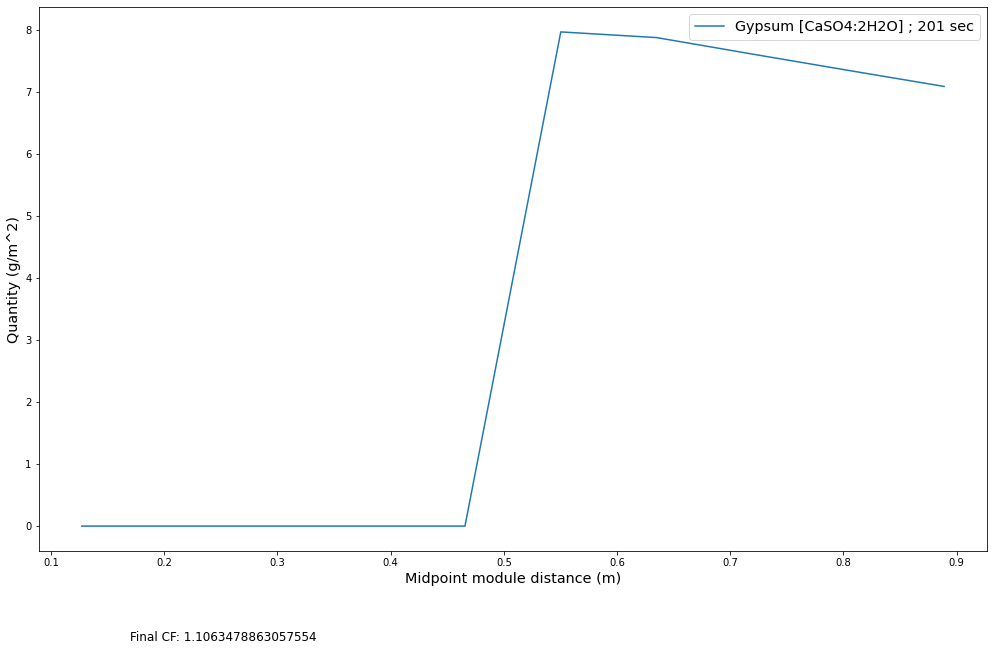

In [69]:
ross = ROSSPkg()

# initial parameters
operating_system = 'windows'
phreeqc_path = 'C:\\Program Files\\USGS\\phreeqc-3.6.2-15100-x64'
database_selection = 'pitzer'
simulation_type = 'transport'
simulation_title = 'test'
water_selection = 'red_sea'
selected_output_path = 'Red Sea_BW30-400_PE=1_1.1'

# create the input file
ross.define_general(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title)
ross.transport(simulation_time = 200)
ross.reaction()
ross.solutions(water_selection = water_selection)
ross.equilibrium_phases()
ross.selected_output()
ross.export(print_block = True)

# ross.input_file(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title, water_selection)

# execute the input file
ross.execute()

# process the simulation results
ross.process_selected_output(selected_output_path)

### Parse the databases

In [16]:
from glob import glob
from numpy import nan
import json


def database_parsing(db):
    print(f'\n\n\n{db}')
    
    database = pandas.read_table(db, sep='\n')
    start_master = False
    if database.columns == ['SOLUTION_MASTER_SPECIES']:
        start_master = True
    database.columns = ['content']

    elements_rows = []
    minerals_rows = []
    elemental_parsing = False
    mineral_parsing = False
    for index, row in database.iterrows():
        if (re.search('SOLUTION_MASTER_SPECIES', row['content']) or start_master) and not elemental_parsing :
            while not re.search('SOLUTION_SPECIES', database.at[index, 'content']):
                split_row = database.at[index, 'content'].split()
                if all(not re.search('^#', entity) for entity in split_row):
                    elements_rows.append(split_row)
                index+= 1
            elemental_parsing = True

        if re.search('PHASES', row['content']) and not mineral_parsing:
            loop = False
            while not re.search('PITZER|EXCHANGE_MASTER_SPECIES|SURFACE_MASTER_SPECIES', database.at[index, 'content']):
                if not loop:
                    minerals_rows.append(['phases', 'formula'])
                    loop = True
                    index += 1
                    continue

                if re.search('(^\w+\s*\d*$)',database.at[index, 'content']):
                    reactants = database.at[index+1, 'content'].split(' = ')[0]
                    if all('#' not in entity for entity in reactants):
                        formula = reactants.split(' + ')[0].strip()
                        name = database.at[index, 'content']
                        #name = re.sub('\s*\d*', '', name)
                        minerals_rows.append([name, formula])
                index+= 1
                
                if index == len(database):
                    break
            mineral_parsing = True

    # define the elements content for the database
    elements = pandas.DataFrame(elements_rows)
    elements.fillna(' ')
#     elements.columns = elements.iloc[0]
    elements.drop([0], inplace = True)
    for column in elements:
        nan_entries = 0
        alphanumeric_entries = 0
        for entry in elements[column]:
#             if entry in [None, ' ', nan]:
            if entry is not None:
                if re.search('[a-z]|[0-9]', entry, re.IGNORECASE) and entry is not None:
    #             if entry is str or entry is float or entry is int:
                    alphanumeric_entries += 1
                else:
                    nan_entries += 1
            else:
                nan_entries += 1
        if nan_entries > alphanumeric_entries and len(elements.columns) > 5:
            print('deleted column: ', column)
            del elements[column]
    
    print(elements)
    elements.columns = ['elements', 'species', 'alk', 'gfw_formula', 'element_gfw']
#     elements.rename(columns = {'SOLUTION_MASTER_SPECIES':'elements'}, inplace = True)
    print(elements)
#         elements = elements.iloc[pandas.RangeIndex(len(elements)).drop([x for x in range(4)])]
    elements_list = list(elements['elements'])

    # define the minerals content for the database
    minerals = pandas.DataFrame(minerals_rows)
    minerals.columns = minerals.iloc[0]
    minerals = minerals.drop(0)
    print(minerals)
    mineral_list = list(minerals['phases'])
    formula_list = list(minerals['formula'])
    
    return elements, minerals
    
    
def database_json_creation(database, elements, minerals):
    database_json = {'elements': {}, 'minerals': {}}
    
    # create the elements JSON
    for index, element in elements.iterrows():
        database_json['elements'][element['elements']] = {'charge_specie': element['alk'], 'gfw_formula':element['gfw_formula'], 'element_gfw':element['element_gfw']}
    
    # create the mienrals JSON
    for index, mineral in minerals.iterrows():
        database_json['minerals'][mineral['phases']] = mineral['formula']     
        
    # export the JSON files
    database_json_name = re.sub('.dat$', '.json', database)
    with open(database_json_name, 'w') as output:
        json.dump(database_json, output, indent = 4)

erroneous_databases = []
for database in glob('./databases/*.dat'):
    try:
        elements, minerals = database_parsing(database)
        database_json_creation(database, elements, minerals)
    except:
        erroneous_databases.append(database)
        print(f'ERROR: {database}')
        
#     elements, minerals = database_parsing(database)
#     database_json_creation(database, elements, minerals)


print(erroneous_databases)
problem_databases = ['./databases\\frezchem.dat', './databases\\iso.dat', './databases\\llnl.dat', './databases\\minteq.dat', './databases\\minteq.v4.dat', './databases\\sit.dat', './databases\\Tipping_Hurley.dat', './databases\\wateq4f.dat']




./databases\Amm.dat
             0       1     2              3        4
1            H      H+  -1.0              H    1.008
2         H(0)      H2     0              H     None
3         H(1)      H+  -1.0              0     None
4            E      e-     0            0.0        0
5            O     H2O     0              O     16.0
6         O(0)      O2     0              O     None
7        O(-2)     H2O     0              0     None
8           Ca    Ca+2     0             Ca    40.08
9           Mg    Mg+2     0             Mg   24.312
10          Na     Na+     0             Na  22.9898
11           K      K+     0              K   39.102
12          Fe    Fe+2     0             Fe   55.847
13      Fe(+2)    Fe+2     0             Fe     None
14      Fe(+3)    Fe+3  -2.0             Fe     None
15          Mn    Mn+2     0             Mn   54.938
16      Mn(+2)    Mn+2     0             Mn     None
17      Mn(+3)    Mn+3     0             Mn     None
18          Al    Al+3 

             0       1  2              3          4
1           Al    Al+3  0             Al    26.9815
2   Alkalinity   HCO3-  1  Ca0.5(CO3)0.5      50.05
3            B  B(OH)3  0              B     10.811
4         B(3)  B(OH)3  0              B  -36.44179
5        C(-4)     CH4  0            CH4  -33.31051
..         ...     ... ..            ...        ...
78       U(+3)     U+3  0              U       None
79       U(+4)     U+4  0              U       None
80       U(+5)    UO2+  0              U       None
81       U(+6)   UO2+2  0              U       None
82          Zn    Zn+2  0             Zn      65.39

[82 rows x 5 columns]
      elements species alk    gfw_formula element_gfw
1           Al    Al+3   0             Al     26.9815
2   Alkalinity   HCO3-   1  Ca0.5(CO3)0.5       50.05
3            B  B(OH)3   0              B      10.811
4         B(3)  B(OH)3   0              B   -36.44179
5        C(-4)     CH4   0            CH4   -33.31051
..         ...     ...  ..   

           0          1    2        3         4
1    Acetate   HAcetate  0.0  Acetate      59.0
2         Ag        Ag+  0.0       Ag  107.8682
3      Ag(1)        Ag+    0       Ag      None
4      Ag(2)       Ag+2    0       Ag      None
5         Al       Al+3  0.0       Al   26.9815
..       ...        ...  ...      ...       ...
221       Yb       Yb+3  0.0       Yb    173.04
222   Yb(+2)       Yb+2  0.0       Yb      None
223   Yb(+3)       Yb+3  0.0       Yb      None
224       Zn       Zn+2  0.0       Zn     65.39
225       Zr  Zr(OH)2+2  0.0       Zr    91.224

[225 rows x 5 columns]
    elements    species  alk gfw_formula element_gfw
1    Acetate   HAcetate  0.0     Acetate        59.0
2         Ag        Ag+  0.0          Ag    107.8682
3      Ag(1)        Ag+    0          Ag        None
4      Ag(2)       Ag+2    0          Ag        None
5         Al       Al+3  0.0          Al     26.9815
..       ...        ...  ...         ...         ...
221       Yb       Yb+3  0.0 

             0       1    2              3        4
1   Alkalinity   CO3-2    1  Ca0.5(CO3)0.5    50.05
2            B  B(OH)3    0              B    10.81
3           Ba    Ba+2    0             Ba   137.33
4           Br     Br-    0             Br   79.904
5            C   CO3-2    2           HCO3  12.0111
6         C(4)   CO3-2    2           HCO3  12.0111
7           Ca    Ca+2    0             Ca    40.08
8           Cl     Cl-    0             Cl   35.453
9            E      e-    0            0.0      0.0
10          Fe    Fe+2    0             Fe   55.847
11           H      H+   -1              H    1.008
12        H(1)      H+   -1            0.0     None
13           K      K+    0              K  39.0983
14          Li     Li+    0             Li    6.941
15          Mg    Mg+2    0             Mg   24.305
16          Mn    Mn+2    0             Mn   54.938
17          Na     Na+    0             Na  22.9898
18           O     H2O    0              O    16.00
19       O(-

             0       1     2         3         4
1           Ag     Ag+   0.0   107.868   107.868
2           Al    Al+3   0.0   26.9815   26.9815
3   Alkalinity   CO3-2   1.0     50.05     50.05
4           As  H3AsO4  -1.0   74.9216   74.9216
5       As(+3)  H3AsO3   0.0   74.9216   74.9216
..         ...     ...   ...       ...       ...
62           U   UO2+2   0.0  238.0290  238.0290
63        U(3)     U+3   0.0  238.0290  238.0290
64        U(4)     U+4   0.0  238.0290  238.0290
65        U(5)    UO2+   0.0  238.0290  238.0290
66        U(6)   UO2+2   0.0  238.0290  238.0290

[66 rows x 5 columns]
      elements species   alk gfw_formula element_gfw
1           Ag     Ag+   0.0     107.868     107.868
2           Al    Al+3   0.0     26.9815     26.9815
3   Alkalinity   CO3-2   1.0       50.05       50.05
4           As  H3AsO4  -1.0     74.9216     74.9216
5       As(+3)  H3AsO3   0.0     74.9216     74.9216
..         ...     ...   ...         ...         ...
62           U   U

### Execute the module

In [37]:
ross = ROSSPkg()

# initial parameters
os = 'windows'
phreeqc_path = 'C:\\Program Files\\USGS\\phreeqc-3.6.2-15100-x64'
database_selection = 'pitzer'
simulation_type = 'transport'
simulation_title = 'test'
water_selection = 'red_sea'

# execute each function of the class
ross.define_general(os, phreeqc_path, database_selection, simulation_type, simulation_title)
ross.transport(module_characteristics = module_characteristics, quantity_of_modules = quantity_of_modules, domain = domain, output_perspective = output_perspective)
ross.reaction(permeate_approach, permeate_efficiency, head_loss, final_cf)
ross.solutions(ross, water_selection = water_selection, custom_water_parameters = custom_water_parameters)
ross.equilibrium_phases(ignored_minerals = ignored_minerals, existing_parameters = existing_parameters)
ross.selected_output()
ross.export()
ross.execute()
ross.process_selected_output(export_figure = export_figure)

final_message = '\n\nThe simulation is complete.'
print('%s\n%s' %(final_message, '='*len(final_message)))

0     elements    NaN     NaN            NaN    NaN   NaN      NaN
1   Alkalinity  CO3-2       1  Ca0.5(CO3)0.5  50.05  None     None
2            B         B(OH)3              0      B          10.81
3           Ba           Ba+2              0     Ba         137.33
4           Br            Br-              0     Br         79.904
5            C          CO3-2              2   HCO3        12.0111
6         C(4)          CO3-2              2   HCO3        12.0111
7           Ca           Ca+2              0     Ca          40.08
8           Cl            Cl-              0     Cl         35.453
9            E             e-              0    0.0            0.0
10          Fe           Fe+2              0     Fe         55.847
11           H             H+             -1      H          1.008
12        H(1)             H+             -1    0.0  None     None
13           K             K+              0      K        39.0983
14          Li            Li+              0     Li          6

NameError: name 'module_characteristics' is not defined

# Draft 1

In [2]:
# import libraries
from matplotlib import pyplot 
from scipy.constants import nano, kilo, milli, liter, day
from itertools import chain
from chempy.properties.water_density_tanaka_2001 import water_density
from pubchempy import get_compounds 
import subprocess
import datetime
import pandas
from math import pi, exp
import time
import os
import re

# calculation constants
simulated_time_over_computational_time = 9.29    


class ROSSPkg():
    def __init__(self):       
        # establish the general organization structures
        self.parameters = {}
        self.variables = {}
        self.results = {}
        self.results['figures'] = {}

        
    def define_general(self, os, phreeqc_path, database_selection, simulation_type, simulation_title)
        '''
        Establish general conditions
        '''
        self.parameters['water_mw'] = get_compounds('water', 'name')[0].molecular_weight
        self.parameters['water_density'] = water_density()
        
        # parameterize the input file
        self.parameters['os'] =  os
        self.parameters['phreeqc_path'] = phreeqc_path
        self.parameters['simulation_type'] = simulation_type
        self.parameters['title'] = simulation_title
        
        title_line = 'TITLE\t %s' %(simulation_title)
        if os == 'Windows':
            self.parameters['database_path'] = phreeqc_path + '\\database\\%s.dat' %(database_selection)
            database_line = 'DATABASE %s' %(database_path)
            self.results['general_conditions'] = [database_line, title_line]
        else:
            self.results['general_conditions'] = [title_line]
            
        # establish the database content
        self.parameters['database_selection'] = database_selection 
        self.database_parsing(database_selection)
            
            
    def database_parsing(self, database_selection):
        db = self.parameters['database_selection']
        database = pandas.read_table(f'./databases/{db}.dat', sep='\n')
        database.columns = ['content']

        elements_rows = []
        minerals_rows = []
        for index, row in database.iterrows():
            if row['content'] == 'SOLUTION_MASTER_SPECIES':
                while database.at[index, 'content'] != 'SOLUTION_SPECIES':
                    split_row = database.at[index, 'content'].split('\t')
                    elements_rows.append(split_row)
                    index += 1
                continue

            if row['content'] == 'PHASES':
                loop = False
                while phreeqc_database.at[index, 'content'] != '# Gases from LLNL...':
                    print(phreeqc_database.at[index, 'content'])
                    if not loop:
                        minerals_rows.append(['phases', 'formula'])
                        loop = True
                        index += 1
                        continue

                    if re.search('(^\w+$)',phreeqc_database.at[index, 'content']):
                        reactants = phreeqc_database.at[index+1, 'content'].split(' = ')[0]
                        formula = reactants.split(' + ')[0].strip()
                        print(formula)
                        minerals_rows.append([phreeqc_database.at[index, 'content'], formula])
                    index += 1

        # define the elements content for the database
        elements = pandas.DataFrame(elements_rows)
        elements.columns = elements.iloc[2]
        elements.rename(columns = {'#element':'elements'}, inplace = True)
        elements = elements.iloc[pandas.RangeIndex(len(elements)).drop([x for x in range(4)])]
        
        element_list = list(elements['elements'])
        self.parameters['element_list'] = []
        for element in element_list:
            if not re.search('\#', element):
                self.parameters['elements_list'].append(element)

        # define the minerals content for the database
        minerals = pandas.DataFrame(minerals_rows)
        minerals.columns = minerals.iloc[0]
        minerals = minerals.drop(0)
        self.parameters['mineral_list'] = list(minerals['phases'])
        self.parameters['formula_list'] = list(minerals['formula'])
        

    def transport(self, module_selection = 'BW30-400', module_characteristics = {}, quantity_of_modules = 1, cells_per_module = 12, domain = 'dual', output_perspective = 'scaling'):
        '''
        Define the TRANSPORT block
        '''
        # parameterize the module 
        if module_selection == 'BW30-400':
            module_diameter =  201                   #mm
            permeate_tube_diameter =  29             #mm
            module_length =  1.016                   #m
            permeate_flow = 40                       #cubic meters / day
            max_feed_flow = 15.9                     #cubic meters / hour
            membrane_thickness = 250 * (milli / nano)   #mm
            feed_thickness = 0.7112                  #mm
            permeate_thickness = 0.3                 #mm
            polysulfonic_layer_thickness = 0.05      #mm 
            support_layer_thickness = 0.15           #mm
            repeated_membrane_thickness = 2 * membrane_thickness + feed_thickness + permeate_thickness + 2 * polysulfonic_layer_thickness + 2 * support_layer_thickness      #mm
            print('\nMembrane thickness:', '%s (mm)' %(repeated_membrane_thickness))

        elif module_selection == 'Custom':
            module_diameter = module_characteristics['diameter']                             #mm
            permeate_tube_diameter = module_characteristics['permeate_diameter']             #mm
            module_length = module_characteristics['length']                                 #m
            permeate_flow = module_characteristics['permeate_flow']                          #cubic meters / day
            max_feed_flow = module_characteristics['feed_flow']                              #cubic meters / day
            membrane_thickness = module_characteristics['membrane_thickness']                #mm
            feed_thickness = module_characteristics['feed_spacer_thickness']
            permeate_thickness = input('- What is the permeate spacer thickness? (mm) __ ')
            polysulfonic_layer_thickness = module_characteristics['polysulfonic_thickness']
            support_layer_thickness = module_characteristics['support_thickness']
            repeated_membrane_thickness = 2 * membrane_thickness + feed_thickness + permeate_thickness + 2 * polysulfonic_layer_thickness + 2 * support_layer_thickness
            print('Thickness of the repeated membrane unit (mm): %s' %(repeated_membrane_thickness))

        self.parameters['quantity_of_modules'] = quantity_of_modules
        self.parameters['cells_per_module'] = cells_per_module
        cell_length = module_length / self.parameters['cells_per_module']     #meters

        # calculate module properties
        module_cross_sectional_area = module_diameter**2 * pi / 4        #squared millimeters
        permeate_tube_cross_sectional_area = permeate_tube_diameter**2 * pi / 4     #squared millimeters
#             filtering_layer_thicknes = (module_diameter - permeate_thickness) / 2         #millimeters
        filtration_cross_sectional_area = module_cross_sectional_area - permeate_tube_cross_sectional_area        #squared millimeters
        feed_cross_sectional_area = (feed_thickness / repeated_membrane_thickness) * filtration_cross_sectional_area     #squared millimeters
        feed_volume = feed_cross_sectional_area * module_length * kilo**2   #cubic meters
        feed_mass = feed_volume * self.parameters['water_density'] * (1 / liter) / kilo    #kilograms, which assumes pure water for mass
        feed_moles = feed_mass * kilo / self.parameters['water_mw'] 

        # calculate fluid flow characteristics
        kinematic_flow_velocity = 9.33E-7    #square meters / second
        feed_velocity = max_feed_flow / (feed_cross_sectional_area * kilo**2) / day     #meters / second
        reynolds_number = feed_velocity * module_length / kinematic_flow_velocity
        print('Reynold\'s number: ', reynolds_number)

        # calculate module cell characteristics
        self.parameters['feed_mass_cell'] = feed_mass / self.parameters['cells_per_module']      #kg
        feed_moles_cell = feed_moles / self.parameters['cells_per_module']    #moles

        # calculate simulation parameters that will populate the PHREEQC simulation 
        timesteps_over_cell = 1
        maximal_timestep = cell_length / feed_velocity * timesteps_over_cell         #seconds, from the Courant condition
        self.parameters['permeate_removal_per_cell'] = maximal_timestep * permeate_flow / day * liter * self.parameters['water_density'] / self.parameters['water_mw'] / self.parameters['cells_per_module']      #moles / cell

        # define the transport black
        transport_line = '\nTRANSPORT'
        cells_line = '-cells\t\t\t%s' %(self.parameters['cells_per_module'])
        
        simulation_shifts = (2*self.parameters['cells_per_module']*self.parameters['quantity_of_modules'])
        shifts_line = '-shifts\t\t\t%s' %(simulation_shifts)
        lengths_line = '-lengths\t\t%s' %(cell_length)
        timestep_line = '-time_step\t\t%s\t# the Courant condition is satisfied with the cell_length of %s m and the feed velocity of %s m/s' %(maximal_timestep, cell_length, feed_velocity)
        initial_time_line = '-initial_time\t\t0'    
        boundary_conditions_line = '-boundary_conditions\tconstant\tconstant \t # Dirichlet boundary condition'
        
        if domain == 'single':
            domain_line = '-stagnant\t\t0\t0\t0\t0 \t # single domain\n#^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'
        elif domain == 'dual':
            domain_line = '-stagnant\t\t1\t1\t0.1\t0.9 \t # dual domain\n#^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'

        self.parameters['output_perspective'] = output_perspective
        if self.parameters['output_perspective'] == 'scaling':
            punch_cells_line = '-punch_cells\t\t1-%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t%s' %(self.parameters['cells_per_module'])
        elif self.parameters['output_perspective'] == 'brine':
            punch_cells_line = '-punch_cells\t\t%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t1'       

        # create the transport block
        self.results['transport_block'] = []
        self.results['transport_block'].extend((transport_line, cells_line, shifts_line, lengths_line, timestep_line, initial_time_line, boundary_conditions_line, domain_line, punch_cells_line, punch_frequency_line))


    def reaction(self, permeate_approach = 'linear permeate', permeate_efficiency = 1, head_loss = -0.15, final_cf = 2):
        '''
        Define the REACTION block
        '''
        cfs = []
        cell_moles = []
        reaction_parameters = []
        iteration = 0
        cumulative_cf = 1 
        self.results['reaction_block'] = []
        for module in range(quantity_of_modules):
            module_previous_moles_removed = 0
            if permeate_approach == 'linear permeate':
                if iteration == 0:
                    initial_moles_cell = feed_moles_cell

                initial_moles_removed = self.parameters['permeate_removal_per_cell'] * 2 / (1 + exp(head_loss))
                final_moles_removed = initial_moles_removed * exp(head_loss)
                try:
                    removed_moles_slope = ((final_moles_removed - initial_moles_removed) / (self.parameters['cells_per_module'])) / permeate_efficiency
                except:
                    removed_moles_slope = 0
                average_moles_removed = (final_moles_removed + initial_moles_removed) / 2
                print('(Removed moles / cell) slope: ', removed_moles_slope)

                for cell in range(self.parameters['cells_per_module']):
                    removed_moles_in_cell = (cell * removed_moles_slope + initial_moles_removed)
                    reaction_parameters.append(removed_moles_in_cell)
                    module_previous_moles_removed += removed_moles_in_cell
                    
                cf = initial_moles_cell / (initial_moles_cell - module_previous_moles_removed)
                cumulative_cf *= cf

                initial_moles_cell -= module_previous_moles_removed
                iteration += 1

            if permeate_approach == 'linear CF':
                module_iteration = 0
                initial_cf = 1

                cf_slope = (final_cf - initial_cf) / self.parameters['cells_per_module']
                for cell in range(self.parameters['cells_per_module']):
                    cell_cf = (cell+1) * cf_slope + initial_cf
                    cfs.append(cell_cf)    

                for cf in cfs:
                    moles_to_be_removed =  feed_moles_cell - (feed_moles_cell / cf)
                    if module_iteration == 0:
                        initial_moles_cell = feed_moles_cell
                        reaction_parameters.append(moles_to_be_removed)
                    if module_iteration > 0:
                        module_previous_moles_removed += reaction_parameters[-1] 
                        reaction_parameter = moles_to_be_removed - module_previous_moles_removed
                        reaction_parameters.append(reaction_parameter)
                        initial_moles_cell -= moles_to_be_removed

                    module_iteration += 1

                cf = cfs[-1]
                cumulative_cf *= cf
                initial_moles_cell = feed_moles_cell - moles_to_be_removed   # moles_to_be_removed = the final quantity of moles is calculated with naming from the linear permeate flux method to be consistent  

            if self.parameters['simulation_type'] == 'transport':
                reaction_line.append('\n')
                for cell in range(self.parameters['cells_per_module']):
                    cell_number = (cell+1) + self.parameters['cells_per_module'] * module
                    reaction_line = 'REACTION %s' %(cell_number)
                    
                    if (cell+1) < self.parameters['cells_per_module']:
                        reaction_line += f'\n\tH2O -1; {reaction_parameters[cell_number-1]}' 
                    elif (cell+1) == self.parameters['cells_per_module']:
                        reaction_line += f'''\n\tH2O -1; {reaction_parameters[cell_number-1]}
        INCREMENTAL_REACTIONS \ttrue''' %(reaction_parameters[cell_number-1])     

                    self.results['reaction_block'].append(reaction_line)

            elif self.parameters['simulation_type'] == 'evaporation':
                parameter_quantity = 15                          
                recursive_assymtote_multiplier = 1.335449219     # ??? arbitrary assignment of kg of water in the simulation?
                total_moles_removed = sum(reaction_parameters)
                initial_evaporation_parameter = total_moles_removed / recursive_assymptote_multiplier
                evaporation_reaction_parameters = ['0', initial_evaporation_parameter]  # ???
                for parameter in range(1, parameter_quantity):
                    evaporation_reaction_parameter = evaporation_reaction_parameters[parameter] * 1/4
                    evaporation_reaction_parameters.append(evaporation_reaction_parameter)

                # define the reaction block
                reaction_line = 'REACTION 1'
                reaction_line += '\n\tH2O -1; '
                reaction_line += ' '.join(evaporation_reaction_parameters) 
                self.parameters['reaction_block'] = [reaction_line]

            # the calculated reaction parameters will be added and printed to a generated PHREEQC input file
            final_solution_mass = initial_moles_cell * self.parameters['water_mw'] / kilo  #kg water mass
            final_cf_cell = self.parameters['feed_mass_cell'] / final_solution_mass
            print('Effluent module %s CF:' %(module + 1), final_cf_cell)

            if self.parameters['os'] == 'Windows':
                self.results['reaction_block'].append('#%s' %(permeate_approach))
                if permeate_approach == 'linear permeate':
                    self.results['reaction_block'].append('''
        #Permeate efficiency parameter: %s
        #Head loss parameter: %s''' %(permeate_efficiency, head_loss))
                self.results['reaction_block'].append('''    #Effluent module %s:
        #Estimated CF: %s
        #Estimated solution mass: %s\n\n''' %(module + 1, cumulative_cf, final_solution_mass))


    def solutions(self, water_selection, custom_water_parameters = {}):
        """
        Specify the SOLUTION block of the simulation.
        """
        import json

        # create the solution line of the input file
        self.results['solution_block'] = []
        self.parameters['water_selection'] = water_selection

        if self.parameters['simulation_type'] == 'transport':
            initial_solution_line = '\nSOLUTION 0\t%s' % (solution_description)
        elif self.parameters['simulation_type'] == 'evaporation':
            initial_solution_line = '\nSOLUTION 1\t%s' % (solution_description)
        self.results['solution_block'].append(initial_solution_line)

        #=============================================================================
        # determine which predefined solution should be simulated

        if water_selection is not None:       
            # import the predefined water body
            water_file_path = f'./water_bodies/{water_selection}.json'
            water_body = json.load(water_file_path)
            
            self.parameters['elements'] = []
            elements_lines = []
            for content, information in water_body.items():
                if content == 'element':
                    for element, information2 in information.items():
                        if element in self.parameters['elements_list']:
                            self.parameters['elements'].append(element)
                            conc = information2['concentration (ppm)']
                            ref = information2['reference']
                            if len(conc) <= 3:
                                elements_lines.append(f'{element}\t\t{conc}\t#{ref}')
                            else:
                                elements_lines.append(f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database')
                                
                elif content == 'temperature':
                    temperature = information['celcius']
                    temperature_reference = information['reference']
                elif content == 'pe':
                    pe = information['value']
                    pe_reference = information['reference']
                elif content == 'Alkalinity':
                    alkalinity = information['value']
                    alkalinity_reference = information['reference'] 
                elif content == 'pH':
                    ph = information['value']
                    ph_reference = information['reference']

        if custom_water_parameters != {}:
            for content, information in custom_water_parameters.items():
                
                if content == 'element':
                    for element, information2 in information.items():
                        conc = information2['concentration (ppm)']
                        ref = information2['reference']
                        if element in self.parameters['elements_list']:
                            if element in self.parameters['elements']:
                                element_index = self.parameters['elements'].index(element)                           
                                if len(conc) <= 3:
                                    elements_lines[element_index] = (f'{element}\t\t{conc}\t#{ref}')
                                else:
                                    elements_lines[element_index] = (f'{element}\t{conc}\t#{ref}')
                            else:
                                self.parameters['elements'].append(element)
                                if len(conc) <= 3:
                                    elements_lines.append(f'{element}\t\t{conc}\t#{ref}')
                                else:
                                    elements_lines.append(f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database')
                                    
                            
                # create the temperature line of the input file
                elif content == 'temperature':                    
                    temperature = custom_water_parameters['temperature']['value']
                    temperature_reference = custom_water_parameters['temperature']['reference']

                elif content == 'pe':       
                    pe = custom_water_parameters['pe']['value']
                    pe_reference = custom_water_parameters['pe']['reference']

                elif content == 'Alkalinity':
                    alkalinity = custom_water_parameters['Alkalinity']['value']
                    alkalinity_reference = custom_water_parameters['Alkalinity']['reference'] 

                elif content == 'pH':
                    ph = custom_water_parameters['ph']['value']
                    ph_reference = custom_water_parameters['ph']['reference']
                    
                    
        # parameterize the lines of the SOLUTIONS block
        temperature_line = f'temp \t {temperature} \t #{temperature_reference}.'
        ph_line = f'pH \t\t {ph} charge #{ph_reference}'
        pe_line = f'pe \t\t {pe} \t   #{pe_reference} // 4.00 is the default (?)'
        alkalinity_line = f'Alkalinity \t {alkalinity} #{alkalinity_reference}'
        unit_line = 'units \t ppm' 
        elements_line = '\n'.join(elements_lines)
        water_mass = self.parameters['feed_mass_cell']
        if water_selection == 'Bakken formation':
            water_line = f'-water \t{water_mass}\t#TDS=300 ppthousand [before fudging]' 
        elif water_selection == 'German Basin':
            water_line = f'-water \t{water_mass}\t#TDS=314 ppthousand [before fudging]'
        else:
            water_line = f'-water \t{water_mass}'

        self.results['solution_block'].extend([temperature_line, ph_line, pe_line, alkalinity_line, unit_line, elements_line, water_line])

        #parameterize the initial module solution
        if self.parameters['simulation_type'] == 'transport':
            total_cells = self.parameters['cells_per_module'] * quantity_of_modules
            feed_solution_line = f'\nSOLUTION 1-{total_cells}\tInitial solution in the RO module'
            self.results['solution_block'].extend([feed_solution_line,'temp \t 25','units \t ppm'])

            for element in elements:
                element_concentration = 0
                element_line = f'{element}\t{element_concentration}'    
                self.results['solution_block'].append(element_line)

            water_line = '-water \t %s' %(self.parameters['feed_mass_cell'])
            self.results['solution_block'].append(water_line)


    def equilibrium_phases(self, block_comment, ignored_minerals = [], existing_parameters = {}):
        """
        Specify the EQUILIBRIUM_PHASES block of the simulation.
        """
        # define mineral sizes for later spacing
        short_mineral_names = ['Barite', 'Gypsum','Halite', 'Natron', 'Quartz', 'Talc','Trona', 'Borax', 'Albite', 'K-mica','Illite', 'Pyrite', 'Sulfur',]
        long_mineral_names = ['Anthophyllite', 'Hexahydrite', 'Leonhardite', 'Nesquehonite', 'Pentahydrite', 'Portlandite','Sepiolite(d)', 'Boric_acid,s', 'K2B4O7:4H2O', 'NaB5O8:5H2O', 'Rhodochrosite', 'Strontianite','Hydroxyapatite', 'Chlorite(14A)', 'Mackinawite', 'Hausmannite', 'Pyrochroite']

        # determine the set of possible minerals 
        remaining_characters = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '(', ')', 'I', '•']
        permitted_auxillary_reagents = ['OH', 'H2O','O']

        self.variables['described_minerals'] = []
        self.variables['described_mineral_formulas'] = []
        for mineral in self.parameters['mineral_list']:
            mineral_index = self.parameters['mineral_list'].index(mineral)
            mineral_formula = self.parameters['formula_list'][mineral_index]

            for element in self.parameters['elements']:
                if re.search(element, mineral_formula):
                    mineral_formula = re.sub(element, '', mineral_formula)

            for reagent in permitted_auxillary_reagents:
                if re.search(reagent, mineral_formula):
                    mineral_formula = re.sub(reagent, '', mineral_formula)

            if all(character in remaining_characters for character in mineral_formula):
                self.variables['described_minerals'].append(mineral)
                self.variables['described_mineral_formulas'].append(formulas[-1])
            else:
                print(f'The {mineral} mineral contained {mineral_formula} remaining characters after substitution with the parameterized elements.')


        # define the equilibrium_phases block
        self.results['equilibrium_phases_block'] = []
        if self.parameters['simulation_type'] == 'transport':
            equilibrium_phases_number = '1-{}'.format(self.parameters['cells_per_module']*quantity_of_modules)
        elif self.parameters['simulation_type'] == 'evaporation':
            equilibrium_phases_number = '1'
            
        equilibrium_phases_line = f'\nEQUILIBRIUM_PHASES {equilibrium_phases_number}\t{block_comment}'
        self.results['equilibrium_phases_block'].append(equilibrium_phases_line)

        # define the equilibrium_phases lines for the code block
        for possible_mineral in self.variables['described_minerals']:
            if possible_mineral not in ignored_minerals:
                formula = {self.variables['described_mineral_formulas'][described_minerals.index(possible_mineral)]
                if possible_mineral in short_mineral_names:
                    mineral_line = f'{possible_mineral}\t\t' 
                elif possible_mineral == 'Ca-Montmorillonite':
                    mineral_line = f'{possible_mineral}'
                else:
                    mineral_line = f'{possible_mineral}\t'

                if possible_mineral in existing_parameters:
                    for key, value in existing_parameters[possible_mineral].items():
                        if key == 'saturation':
                            mineral_saturation = value['saturation']
                            mineral_line += f'\t{mineral_saturation}'
                        if key == 'initial_moles':
                            initial_moles = value['initial_moles']
                            mineral_line += f'\t{initial_moles}'
                else:
                    mineral_line += f'\t0\t0'
                    
                self.results['equilibrium_phases_block'].append(mineral_line)        


    def selected_output(self, output_filename = None):
        '''
        Specify the output file after a PHREEQC simulation
        '''
        # create parameter lines 
        if output_filename is not None:
            count = 0
            selected_output_file_name = '{}_{}_{}_{}_{}_{}'.format(datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count) 
            while os.path.exists(f'{selected_output_file_name}.txt':
                count += 1
                selected_output_file_name = '{}_{}_{}_{}_{}_{}'.format(datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count) 
        else:
            selected_output_file_name = output_filename

        selected_output_file_name += '.txt'
        self.parameters['selected_output_file_name'] = selected_output_file_name

        minerals_line = ''
        for mineral in self.parameters['elements']:
             minerals_line += f' {mineral}'

        elements_line = ''
        for element in self.parameters['elements']:
             elements_line += f' {element}'

        # define parameter lines
        first_line = '\nSELECTED_OUTPUT'
        file_name_line = f'-file\t\t\t{selected_output_file_name}'
        reaction_line = '-reaction\t\ttrue'
        temperature_line = '-temperature\t\ttrue'
        total_elements_line = '-totals\t\t\t' + elements_line    
        saturation_indices_line = f'-saturation_indices\t{minerals_line}'
        equilibrium_phases_line = f'-equilibrium_phases\t{minerals_line}'
        ph_line = '-pH\t\t\ttrue'
        solution_line = '-solution'
        time_line = '-time\t\t\ttrue'
        distance_line = '-distance\t\ttrue'
        simulation_line = '-simulation\t\ttrue'
        high_precision_line = '-high_precision\ttrue'
        step_line = '-step'
        water_line = '-water'

        # establish the selected_output_block
        self.results['selected_output_block'] = []
        self.results['selected_output_block'].extend((first_line, file_name_line, reaction_line, temperature_line, total_elements_line, saturation_indices_line, equilibrium_phases_line, ph_line, time_line, distance_line, simulation_line, high_precision_line, solution_line, step_line,water_line))


    def export(self, print_block = True):
        """
        View and export the PHREEQC input file
        """
        self.results['complete_lines'] = chain(general_conditions, self.results['solution_block'], self.results['equilibrium_phases_block'], self.results['reaction_block'], self.results['selected_output_block'], self.results['transport_block']) 

        # create the export input file
        file_number = 0
        proposed_file_name = '%s_ROSS_%s_%s_%s.pqi' %(datetime.date.today(), self.parameters['water_selection'], self.parameters['output_perspective'], file_number)
        if not os.path.exists(proposed_file_name):
            self.parameters['input_file_name'] = proposed_file_name
        elif os.path.exists(proposed_file_name):
            while os.path.exists('%s_ROSS_%s_%s_%s_%s.pqi' %(datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['output_perspective'], file_number)):
                file_number += 1
                self.parameters['input_file_name'] = '%s_ROSS_%s_%s_%s_%s.pqi' %(datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['output_perspective'], file_number)

        # printing and exporting the input file
        input_file = open(self.parameters['input_file_name'],'a')
        for line in self.results['complete_lines']:
            if printing_block:
                print(line)
            input_file.write(line + '\n')
        input_file.close()


    def execute(self, input_path = None, output_path = None):
        '''
        Execute the input file through the batch PHREEQC software 
        '''
        # define the file paths for the simulation input and output
        if input_path is None:
            working_directory = os.getcwd()
            input_path = os.path.join(working_directory, self.parameters['input_file_name'])
        if output_path is None:
            output_file_name = re.sub('(?<=\.)(.+)' , 'pqo', input_file_name)        
            output_path = os.path.join(working_directory, output_file_name)

        # locate the batch PHREEQC software
        bat_path = os.path.join(self.parameters['phreeqc_path'], 'bin\\phreeqc.bat')

        # execute command for the PHREEQC calculations
        proc = subprocess.Popen('cmd.exe', stdin=subprocess.PIPE)
        command = str.encode("\"" + bat_path + "\" \"" + input_path + "\" \"" + output_path + "\"  \"" + database_path + "\"\n") 
        proc.stdin.write(command)
        proc.stdin.close()  
        proc.wait()

        # verify that the PHREEQC executed and generated the appropriate files
        if os.path.exists(output_path):
            if os.path.exists(self.parameters['selected_output_file_name']):
                print('The execution is complete.')
            else:
                print('ERROR: The SELECTED_OUTPUT file is missing. The simulation failed to simulate.')
        else:
            print('\nERROR: The simulation failed to execute.')


    def process_selected_output(self,selected_output_path = None, graphical_selection = 'scaling', plot_title = '', title_font = 'xx-large', x_label = , y_label = '', label_font = 'x-large', plot_caption = None, table_title = None, export_figure = True, export_format = 'svg', individual_plots = True):
        """
        Interpreting the PHREEQC SELECTED_OUTPUT file and conducting the plotting functions
        """
        self.parameters['graphical_selection'] = graphical_selection

        # determining the appropriate variables
        if selected_output_path is not None:
            #determining the scope of the simulation data
            if re.search('(scaling)', selected_output_path, flags=re.IGNORECASE):
                self.parameters['output_perspective'] = 'scaling'
            elif re.search('(brine)', selected_output_path, flags=re.IGNORECASE):
                self.parameters['output_perspective'] = 'brine'
                                 
            for line in selected_output_path:
                if re.search('(TRANSPORT)', line):
                    self.parameters['simulation_type'] = 'transport'
                else:
                    self.parameters['simulation_type'] = 'evaporation'
        else:
            working_directory = os.getcwd()
            selected_output_path = os.path.join(working_directory, self.parameters['selected_output_file_name'])                     

        # preparing the SELECTED_OUTPUT file into a dataframe
        selected_output = open(selected_output_path, 'r')
        original_data = pandas.read_table(selected_output, sep = '\t')
        self.results['csv_data'] = pandas.DataFrame(original_data)
        for column in self.results['csv_data'].columns:
            new_column = column.strip()
            self.results['csv_data'].rename(columns={column:new_column}, inplace = True)

        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
        final_solution_mass = self.results['csv_data']['mass_H2O'].iloc[-1]
        self.variables['simulation_cf'] = self.variables['initial_solution_mass'] / final_solution_mass
                                 
        # conducting the appropriate visualization function
        if self.parameters['graphical_selection'] == 'brine':
            self.brine_plot(plot_title = 'Effluent brine elemental concentrations', title_font, label_font, plot_caption, table_title, export_figure, export_format)
        elif self.parameters['graphical_selection'] == 'scaling':
            self.scaling_plot(plot_title = 'scaling throughout the RO module', title_font, label_font, plot_caption, table_title, individual_plots, export_figure)


    def brine_plot(self, plot_title, title_font, label_font, plot_caption, table_title, export_figure, export_format):
        """
        Generate plots of the elemental concentrations from effluent brine in the PHREEQC SELECTED_OUTPUT file  
        """
        elements = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z][a-z]?(\(\d\))?){1}$', column) and not re.search('(_|H2O|pH)', column):
                elements.append(column)

        self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # plot the brine concentrations figure
        unit = 'mol/kgw'
        concentration_array = []
        pyplot.figure(figsize = (17,10))
        pyplot.xlabel('time (s)', fontsize = label_font)
        pyplot.ylabel('concentration (ppm)', fontsize = label_font)
        pyplot.grid(True)

        for element in elements:  
            concentration_serie = []
            time_serie = []
            initial_solution_time = 0
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'Cl'] == 0:
                    initial_solution_time += 1
                else:
                    concentration_serie.append(self.results['csv_data'].at[index, element])
                    delta_time = self.results['csv_data'].at[index, 'time'] - self.results['csv_data'].at[index-1, 'time']
                    time_serie.append(self.results['csv_data'].at[index, 'time'] - initial_solution_time * delta_time)

            pyplot.plot(time_serie,concentration_serie)

        pyplot.legend(elements, loc='best', title = 'non-zero elements', fontsize = 'x-large')
        pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
        pyplot.yscale('log')
        figure = pyplot.gcf()
        print('\nClose the figure to proceed.')
        if plot_caption is None:
            plot_caption = '''\n\nbrine Figure:\n%s 
                    The effluent concentrations of each existing element in the brine. brine plots from brine data rapidly reach a steady state elemental concentration. brine plots from scaling data consist of vertical concentrations that represent the concentrations at each distance throughout the RO module at the specified time, where the low end represents the influent concentration while the high end represents the effluent concentration.''' %('='*len('brine Figure'))
                                 
        print(plot_caption)
        pyplot.show()

        # create a complementary concentration data table
        loop_iteration = 1
        table_view = {}
        average_concentrations_table = pandas.DataFrame()
        index_elements = []
        if self.parameters['output_perspective'] == 'scaling':
            for element in self.parameters['elements']:
                quantity_of_steps_index = 0
                average_iteration = 0
                time_serie = []            
                time_averages = {}
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'time'] == 0:
                        time_serie.append(self.results['csv_data'].at[index,element])                 
                        quantity_of_steps_index += 1                    

                    elif self.results['csv_data'].at[index-1,'soln'] == quantity_of_steps_index:       
                        #process the complete time serie
                        try:
                            average_concentration = sum(time_serie) / len(time_serie)
                        except:
                            average_concentration = 0

                        #print(average_concentration)
                        table_view['Time (s): %s' %(average_iteration * quantity_of_steps_index)] = average_concentration
                        average_iteration += 1 

                        #begin the new time serie
                        time_serie = []
                        time_averages = {}
                        time_serie.append(self.results['csv_data'].at[index,element])  

                    elif index == len(self.results['csv_data'][element]) + 2:       
                        time_serie.append(self.results['csv_data'].at[index,element])            
                        try:
                            average_concentration = sum(time_serie) / len(time_serie)
                        except:
                            average_concentration = 0
                        table_view['Time (s): %s' %(round(average_iteration * quantity_of_steps_index), 1)] = average_concentration
                        average_iteration += 1
                        index_elements.append(element)
                        average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
                        loop_iteration += 1

                    else:
                        time_serie.append(self.results['csv_data'].at[index,element])

            # defining the index column of the DataFrame
            average_concentrations_table.index = index_elements
            average_concentrations_table.index.name = 'Elements'
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module for each %s seconds of simulation:' %(quantity_of_steps_index)

        # create a complementary concentration data table for the brine figure 
        elif self.parameters['output_perspective'] == 'brine':
            total_time = self.results['csv_data']['time'].iloc[-1]
            for element in elements:  
                concentration_serie = []
                time_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'Cl'] != 0:
                        concentration_serie.append(self.results['csv_data'].at[index,element])      
                average_concentration = sum(concentration_serie) / len(concentration_serie)
                table_view['%s' %(element)] = average_concentration

            average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
            average_concentrations_table.rename(index = {0:'Concentrations (molal)'}, inplace = True)
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module over %s seconds of simulation:' %(total_time)

        print('\n\n\n',table_title,'\n%s'%('='*len(table_title)))
        print(average_concentrations_table)

        # export the graphic
        if export_figure:
            filename_core = re.sub('(\.\w+)', '', self.parameters['selected_output_file_name'])
            if not re.search('(scaling|brine)', filename_core, flags=re.IGNORECASE):
                export_name = '{}-{}'.format(filename_core, self.parameters['output_perspective'])
            else:
                export_name = filename_core

            self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
            self.export_plot(export_name, export_format)
                                 

    def scaling_plot(self, plot_title, title_font, label_font, plot_caption, table_title, individual_plots, export_figure):
        """
        Generate plots of scaling along the module distance in the PHREEQC SELECTED_OUTPUT file  
        """
        def series_creation():
            iteration = 0
            distance_serie = []
            time_serie = []
            quantity_of_steps_index = 0   
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'time'] == 0:
                    time_serie.append(self.results['csv_data'].at[index, mineral]) 
                    distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    quantity_of_steps_index += 1   
                    time = 0

                elif self.results['csv_data'].at[index-1, 'soln'] == quantity_of_steps_index:
                    experimental_loop.append(f'{mineral} [{mineral_formula}] ; time: {round(time)} s')
                    pyplot.plot(distance_serie,time_serie)
                    distance_serie = []
                    time_serie = []
                    time_serie.append(self.results['csv_data'].at[index, mineral])
                    distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    time = self.results['csv_data'].at[index, 'time']

                elif index == len(self.results['csv_data'][mineral]) + 2:   
                    experimental_loop.append(f'{mineral} [{mineral_formula}] ; time: {round(time)} s')
                    pyplot.plot(distance_serie,time_serie)

                else:
                    time_serie.append(self.results['csv_data'].at[index, mineral])
                    distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    iteration += 1
                                 
            return experimental_loop
                                 
                                 
        self.parameters['individual_plots'] = individual_plots
                                 
        # the complete list of all minerals is created
        csv_minerals = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z].{3,})', column) and not re.search('(\(|\_|\:)', column):
                csv_minerals.append(column)

        if self.parameters['simulation_type'] == 'transport':
            self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # all of the non-zero minerals are identified and the chemical formulas are sorted into a list
        non_zero_minerals = set()
        for mineral in csv_minerals:
            for value in self.results['csv_data'][mineral]:
                if value != 0:
                    non_zero_minerals.add(mineral)

        quantity_nonzero_minerals = len(non_zero_minerals)         

        # plot the simulation depending upon the simulation perspective
        unit = 'moles'
        if self.parameters['output_perspective'] == "brine":
            individual_plots = 'n'
            pyplot.figure(figsize = (17,10))
            pyplot.title(plot_title, fontsize = title_font)
            pyplot.xlabel('Time (s)', fontsize = label_font)
            pyplot.ylabel('Quantity (ppm)', fontsize = label_font)  
            experimental_loop = []
            formula_index = 0
            for mineral in non_zero_minerals:
                mineral_index = self.parameters['mineral_list'].index(mineral)
                mineral_formula = self.parameters['formula_list'][mineral_index] 
                                 
                mineral_serie = []
                time_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    mineral_serie.append(self.results['csv_data'].at[index, mineral]) 
                    time = self.results['csv_data'].at[index, 'time']
                    time_serie.append(time)

                pyplot.plot(time_serie,mineral_serie)
                pyplot.scatter(time_serie,mineral_serie)

                experimental_loop.append(f'{mineral} [{mineral_formula}]')   

            pyplot.legend(experimental_loop, loc='best', fontsize = 'x-large')
            pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
            figure = pyplot.gcf()
            print('\nClose the figure to proceed.\n')
            pyplot.show()

            if export_figure:
                export_filename_progenitor = re.sub('(\.\w+)', '', selected_output_file_name)
                if not re.search('(scaling|brine)', export_filename_progenitor, flags=re.IGNORECASE):
                    export_name = '{}, {}'.format(export_filename_progenitor, self.parameters['output_perspective'])
                else:
                    export_name = export_filename_progenitor

                self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
                self.export_plot(export_name, export_format)

        elif self.parameters['output_perspective'] == 'scaling':
            if quantity_nonzero_minerals < 2:
                individual_plots = 'n'
            elif quantity_nonzero_minerals >= 2:
                individual_plots = 'y'
            print(f'\nQuantity of precipitated minerals: {quantity_nonzero_minerals}')

            if individual_plots:
                for mineral in non_zero_minerals:
                    mineral_index = self.parameters['mineral_list'].index(mineral)
                    mineral_formula = self.parameters['formula_list'][mineral_index] 
                                 
                    pyplot.figure(figsize = (17,10))
                    pyplot.title(plot_title, fontsize = title_font)

                    if self.parameters['simulation_type'] == 'transport':
                        pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
                        pyplot.ylabel('Quantity (ppm)', fontsize = label_font)  
                        experimental_loop = []

                        experimental_loop = series_creation()
                        

                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        experimental_loop = []
                        cf_series = []
                        concentration_series = []
                        data_length = len(self.results['csv_data']['mass_H2O'])
                        for index, row in self.results['csv_data'].iterrows():
                            if index < data_length:
                                if self.results['csv_data'].at[index, 'step'] >= 1:
                                    concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                    solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                    cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  
                                elif index > 1:
                                    print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')

                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                        cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                        experimental_loop.append(f'{mineral} [{mineral_formula}]')
                        pyplot.plot(cf_series,concentration_series)                    

                    pyplot.legend(experimental_loop, loc='best', fontsize = label_font)
                    pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
                    figure = pyplot.gcf()
                    print('\nClose the figure to proceed.')
                    pyplot.show()

                    # export the direct figures
                    if export_figure:
                        export_filename_progenitor = re.sub('(\.\w+)', '', selected_output_file)
                        if not re.search('(scaling|brine)', export_filename_progenitor, flags=re.IGNORECASE):
                            export_name = '{}, {}'.format(export_filename_progenitor, self.parameters['output_perspective'])
                        else:
                            export_name = export_filename_progenitor
                                                         
                        export_name += f'_{mineral}'

                        self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
                        self.export_plot(export_name, export_format)


            elif not individual_plots:
                pyplot.figure(figsize = (17,10))
                pyplot.title(plot_title, fontsize = tital_font)
                pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
                pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  
                experimental_loop = []
                for mineral in non_zero_minerals:
                    if self.parameters['simulation_type'] == 'transport':
                        experimental_loop = series_creation()


                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        experimental_loop = []
                        iteration = 0
                        mass_series = []
                        concentration_series = []
                        quantity_of_steps_index = 0  
                        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
                        for index, row in self.results['csv_data'].iterrows():
                            try:
                                if self.results['csv_data'].at[index+1, 'mass_H2O']:
                                    if self.results['csv_data'].at[index, 'step'] >= 1:
                                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                        mass_series.append(self.variables['initial_solution_mass'] / solution_mass)   
                                    else:
                                        print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')


                            except:
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                mass_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                                experimental_loop.append(f'{mineral} [{mineral_formula}]' 
                                pyplot.plot(mass_series,concentration_series)

                                mass_series = []
                                concentration_series = []
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                mass_series.append(self.variables['initial_solution_mass'] / solution_mass)         


                pyplot.legend(experimental_loop, loc='best', fontsize = label_font)
                pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
                figure = pyplot.gcf()
                print('\nClose the figure to proceed.')
                pyplot.show()

                # export the output graphic
                if export_figure:
                    export_filename_progenitor = re.sub('(\.\w+)', '', selected_output_file)
                    if not re.search('(scaling|brine)', export_filename_progenitor, flags=re.IGNORECASE):
                        export_name = '{}, {}'.format(export_filename_progenitor, self.parameters['output_perspective'])
                    else:
                        export_name = export_filename_progenitor 

                    self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
                    self.export_plot(export_name, export_format)


    def export_plot(self, export_name, export_format = 'svg'):
        """
        Export the plots to the current working directory  
        """
        file_number = 0
        if not os.path.exists('%s.%s' %(export_name, export_format)):
            figure.savefig('%s.%s' %(export_name, export_format))
        elif os.path.exists('%s.%s' %(export_name, export_format)):
            while os.path.exists('%s_%s.%s' %(export_name, file_number, export_format)):
                file_number += 1
            figure.savefig('%s_%s.%s' %(export_name, file_number, export_format))


    def complete_simulation(self, os, phreeqc_path, database_selection, simulation_type, simulation_title, water_selection, quantity_of_modules = 1, module_characteristics = {}, output_perspective = 'scaling', domain = 'dual', permeate_efficiency = 1, head_loss = -0.15, , custom_water_parameters = {}, ignored_minerals = [], existing_parameters = {}, export_figure = True):
        """
        Concisely execute a complete run of the software  
        """
        self.define_general(self, os, phreeqc_path, database_selection, simulation_type)
        self.transport(module_characteristics = module_characteristics, quantity_of_modules = quantity_of_modules, domain = domain, output_perspective = output_perspective)
        self.reaction(permeate_approach, permeate_efficiency, head_loss, final_cf)
        self.solutions(self, water_selection = water_selection, custom_water_parameters = custom_water_parameters):
        self.equilibrium_phases(self, ignored_minerals = ignored_minerals, existing_parameters = existing_parameters)
        self.selected_output()
        self.export()
        self.execute()
        self.process_selected_output(export_figure = export_figure)
                                                         
        final_message = '\n\nThe simulation is complete.'
        print('%s\n%s' %(final_message, '='*len(final_message)))

Will you visualize simulation results?
    < y > or < n > ___ n
Will you create an input file?
    < y > or < n > ___ n
Will you execute a simulation?
    < y > or < n >y
sixth
What is the input file name?n
n


TypeError: 'str' object is not callable

# Brainstorming

In [7]:
def skipping():
    skips = 0 
    return 0 

skips = skipping()
print(skips)

0


In [ ]:
from chemicals import periodic_table
# define elemental masses
elemental_masses = {}
for element in periodic_table:
    elemental_masses[element.symbol] = element.MW

described_minerals = {'Hydroxylapatite': {'formula': 'Ca5(PO4)3OH'}, 
                      'Vivianite': {'formula': 'Fe3(PO4)2:8H2O'},
                      'FCO3Apatite': {'formula': 'Ca9.316Na0.36Mg0.144(PO4)4.8(CO3)1.2F2.48'}
                     }


for mineral in described_minerals:
    formula = described_minerals[mineral]['formula']
    print(f'\n\n{mineral} {formula}\n', '='*len(f'{mineral} {formula}'), '\n')
    described_minerals[mineral]['mass'] = 0
    mass = 0
    stoich = None
    first = True
    for ch_number in range(len(formula)):
        print('mass', described_minerals[mineral]['mass'])
        print('ch_number', ch_number)
        character = formula[ch_number]
        print('character', character)
        
        if re.search('[A-Z]', character):
            if first:
                element = character
            else:
                mass = element * stoich
                described_minerals[mineral]['mass'] += mass
                
                element = character
                stoich = None
                
        elif re.search('[a-z]', character):
            element += character
        elif re.search('[0-9\.]', character):
            if stoich is None:
                stoich = character
            else:
                stoich += character 

    if re.search('[0-9]',formula[ch_number]):
        stoich = formula[ch_number]
        subbed = re.sub('H|2|O', '', formula[ch_number+1:ch_number+4])
        if subbed == '':
            skip_characters = 3
            water_mass = elemental_masses['H'] * 2 + elemental_masses['O']
            mass = float(stoich) * water_mass
            return skip_characters, mass
        else:
            print(f'--> ERROR: The {formula} formula is not predictable.')
                
                
                
                
        
        if skip_characters > 0:
            skip_characters -= 1
            continue
            
        final = False
        if ch_number == len(formula)-1:
            final = True
            
        if formula[ch_number] == ':':
            continue
        elif formula[ch_number] == '(':
            group_mass = 0
            ch_no2 = ch_number + 1
            while formula[ch_no2] != ')':
                if skip_characters > 0:
                    skip_characters -= 1
                    ch_no2 += 1
                    continue
                    
                skips, mass = parse_mineral_formula(formula, ch_no2, group = True, final = final)
                group_mass += mass
                skip_characters += skips
                ch_no2 += 1
                
            ch_no2 += 1
            print('group_mass', group_mass)
            skips, stoich = parse_stoich(formula, ch_no2)
#             stoich = re.search('[0-9]', formula[ch_no2])
#             if stoich is not None:
#                 group_mass *= float(stoich.group())
            print('group_stoich', stoich)
            described_minerals[mineral]['mass'] += group_mass * stoich
            skip_characters = ch_no2 - ch_number 
            print(skip_characters)
        else:
            skip_characters, mass = parse_mineral_formula(formula, ch_number, final = final)
            described_minerals[mineral]['mass'] += mass
            

In [6]:
from chemicals import periodic_table
import re
# define elemental masses
elemental_masses = {}
for element in periodic_table:
    elemental_masses[element.symbol] = element.MW

described_minerals = {'Hydroxylapatite': {'formula': 'Ca5(PO4)3OH'}, 
                      'Vivianite': {'formula': 'Fe3(PO4)2:8H2O'},
                      'FCO3Apatite': {'formula': 'Ca9.316Na0.36Mg0.144(PO4)4.8(CO3)1.2F2.48'}
                     }

# determine the molecular mass for each mineral

def parse_stoich(formula, ch_number):
    ch_no = ch_number
    stoich = ''
    while re.search('[0-9\.]', formula[ch_no]):                    
        stoich += formula[ch_no]
        if ch_no == len(formula)-1:
            break
        ch_no += 1
#         print(stoich)
    skips = ch_no - ch_number
    return skips, float(stoich)

def parse_mineral_formula(formula, ch_number, final, group = False):
    if re.search('[A-Z]',formula[ch_number]):
        if final:
            element = formula[ch_number]
            print('\n', element)
            stoich = 1
            
            print('elemental_mass', elemental_masses[element])
            print('stoich', stoich)
            mass = stoich * elemental_masses[element] 
            skip_characters = 0
            print('mass', mass)
            return skip_characters, mass
        
        elif re.search('[a-z]', formula[ch_number+1]):
            element = formula[ch_number] + formula[ch_number+1]
            print('\n', element)
            if re.search('[0-9]', formula[ch_number+2]):
                skips, stoich = parse_stoich(formula, ch_number+2) # float(formula[ch_number+2])
            elif formula[ch_number] == '':
                stoich = 1
            else:
                print('--> ERROR: The mineral formula {} is unpredictable.'.format(formula))

            print('elemental_mass1', elemental_masses[element])
            print('stoich1', stoich)
            mass = stoich * elemental_masses[element] 
            skip_characters = skips + 1
            print('mass1', mass)
            return skip_characters, mass

        elif re.search('[0-9]', formula[ch_number+1]):
            skips, stoich = parse_stoich(formula, ch_number+1)
                
            element = formula[ch_number]
            print('\n', element)
            stoich = float(stoich)
            
            print('elemental_mass2', elemental_masses[element])
            print('stoich2', stoich)
            mass = stoich * elemental_masses[element] 
            skip_characters = skips  + 1
            print('mass2', mass)
            return skip_characters, mass

        elif re.search('[A-Z]', formula[ch_number+1]):
            element = formula[ch_number]
            print('\n', element)
            stoich = 1
            
            print('elemental_mass3', elemental_masses[element])
            print('stoich3', stoich)
            mass = stoich * elemental_masses[element] 
            skip_characters = 0
            print('mass3', mass)
            return skip_characters, mass
        
    if re.search('[0-9]',formula[ch_number]):
        stoich = formula[ch_number]
        subbed = re.sub('H|2|O', '', formula[ch_number+1:ch_number+4])
        if subbed == '':
            skip_characters = 3
            water_mass = elemental_masses['H'] * 2 + elemental_masses['O']
            mass = float(stoich) * water_mass
            return skip_characters, mass
        else:
            print(f'--> ERROR: The {formula} formula is not predictable.')

#         elif mineral[ch_number] == '(':
            

for mineral in described_minerals:
    formula = described_minerals[mineral]['formula']
    print(f'\n\n{mineral} {formula}\n', '='*len(f'{mineral} {formula}'), '\n')
    skip_characters = 0
    described_minerals[mineral]['mass'] = 0
    mass = 0
    for ch_number in range(len(formula)):
        print('mass', described_minerals[mineral]['mass'])
        print('ch_number', ch_number)
        print('character', formula[ch_number])
        if skip_characters > 0:
            skip_characters -= 1
            continue
            
        final = False
        if ch_number == len(formula)-1:
            final = True
            
        if formula[ch_number] == ':':
            continue
        elif formula[ch_number] == '(':
            group_mass = 0
            ch_no2 = ch_number + 1
            while formula[ch_no2] != ')':
                if skip_characters > 0:
                    skip_characters -= 1
                    ch_no2 += 1
                    continue
                    
                skips, mass = parse_mineral_formula(formula, ch_no2, group = True, final = final)
                group_mass += mass
                skip_characters += skips
                ch_no2 += 1
                
            ch_no2 += 1
            print('group_mass', group_mass)
            skips, stoich = parse_stoich(formula, ch_no2)
#             stoich = re.search('[0-9]', formula[ch_no2])
#             if stoich is not None:
#                 group_mass *= float(stoich.group())
            print('group_stoich', stoich)
            described_minerals[mineral]['mass'] += group_mass * stoich
            skip_characters = ch_no2 - ch_number + skips - 1
            
            print(skip_characters)
        else:
            skip_characters, mass = parse_mineral_formula(formula, ch_number, final = final)
            described_minerals[mineral]['mass'] += mass
            
    print('{} mass: {}'.format(mineral, described_minerals[mineral]['mass']))



Hydroxylapatite Ca5(PO4)3OH

mass 0
ch_number 0
character C

 Ca
3
elemental_mass1 40.078
stoich1 5.0
mass1 200.39000000000001
mass 200.39000000000001
ch_number 1
character a
mass 200.39000000000001
ch_number 2
character 5
mass 200.39000000000001
ch_number 3
character (

 P
elemental_mass3 30.973761
stoich3 1
mass3 30.973761
7

 O
elemental_mass2 15.9994
stoich2 4.0
mass2 63.9976
group_mass 94.971361
9
group_stoich 3.0
5
mass 485.304083
ch_number 4
character P
mass 485.304083
ch_number 5
character O
mass 485.304083
ch_number 6
character 4
mass 485.304083
ch_number 7
character )
mass 485.304083
ch_number 8
character 3
mass 485.304083
ch_number 9
character O

 O
elemental_mass3 15.9994
stoich3 1
mass3 15.9994
mass 501.30348299999997
ch_number 10
character H

 H
elemental_mass 1.00794
stoich 1
mass 1.00794
Hydroxylapatite mass: 502.311423


Vivianite Fe3(PO4)2:8H2O

mass 0
ch_number 0
character F

 Fe
3
elemental_mass1 55.845
stoich1 3.0
mass1 167.535
mass 167.535
ch_number 1
character 

In [151]:
import pandas

database = pandas.read_table('./databases/Tipping_hurley.dat', sep='\n')
# database.columns = ['content']
#     for index, row in database.iterrows():
    
print(database)
for index, row in database.iterrows():
    print(row)
    

     #  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $
0     # Revised arsenic data from Archer and Nordstr...    
1                               SOLUTION_MASTER_SPECIES    
2     Ag       Ag+            0.0     107.868       ...    
3     Al       Al+3           0.0     26.9815       ...    
4     Alkalinity CO3-2        1.0     50.05         ...    
...                                                 ...    
3342          H_cfH2 + Pb+2 = H_cfPb + 2H+; log_k -3.85    
3343          H_chH2 + Pb+2 = H_chPb + 2H+; log_k -3.85    
3344          H_deH2 + Pb+2 = H_dePb + 2H+; log_k -3.85    
3345          H_dgH2 + Pb+2 = H_dgPb + 2H+; log_k -3.85    
3346                                                END    

[3347 rows x 1 columns]
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    # Revised arsenic data from Archer and Nordstr...
Name: 0, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    SOLUTION_MASTER_SPECIES
Name: 1, dtype: object
#  $Id: wateq4f.dat

Name: 602, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           14.0
Name: 603, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h 5.4 kcal
Name: 604, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    #CaHSO4+             168
Name: 605, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Ca+2 + HSO4- = CaHSO4+ 
Name: 606, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           1.08
Name: 607, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    #Mn+3 secondary master species   169
Name: 608, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Mn+2 = Mn+3 + e- 
Name: 609, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           -25.51
Name: 610, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h 25.

Name: 1155, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    #S4-2                504
Name: 1156, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            HS- = S4-2 + H+                 # (lhs...
Name: 1157, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           -9.829
Name: 1158, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h 9.7 kcal
Name: 1159, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            -no_check
Name: 1160, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            -mass_balance   S(-2)4
Name: 1161, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            -gamma  10.0    0.0
Name: 1162, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    #S5-2                505
Name: 1163, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            HS-

Name: 1684, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           0.125
Name: 1685, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h -2.802 kcal
Name: 1686, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    Fluorite            62
Name: 1687, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            CaF2 = Ca+2 + 2F- 
Name: 1688, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           -10.6
Name: 1689, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h 4.69 kcal
Name: 1690, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            -analytical     66.348  0.0     -4298....
Name: 1691, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    Montmorillonite-Ca     63
Name: 1692, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $        

Name: 2240, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            PbCl2:PbCO3 = 2Pb+2 + 2Cl- + CO3-2 
Name: 2241, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           -19.810
Name: 2242, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    Cerrusite           365
Name: 2243, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            PbCO3 = Pb+2 + CO3-2 
Name: 2244, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           -13.13
Name: 2245, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            delta_h 4.86 kcal
Name: 2246, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    PbF2                366
Name: 2247, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            PbF2 = Pb+2 + 2F- 
Name: 2248, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $          

Name: 2783, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Cu+2 + 2X- = CuX2
Name: 2784, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           0.6
Name: 2785, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Zn+2 + 2X- = ZnX2
Name: 2786, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           0.8
Name: 2787, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Cd+2 + 2X- = CdX2
Name: 2788, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           0.8
Name: 2789, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Pb+2 + 2X- = PbX2
Name: 2790, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            log_k           1.05
Name: 2791, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $            Al+3 + 3X- = AlX3
N

Name: 3320, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_cfH2 + Cd+2 = H_cfCd + 2H+; log_k -7.09
Name: 3321, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_chH2 + Cd+2 = H_chCd + 2H+; log_k -7.09
Name: 3322, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_deH2 + Cd+2 = H_deCd + 2H+; log_k -7.09
Name: 3323, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_dgH2 + Cd+2 = H_dgCd + 2H+; log_k -7.09
Name: 3324, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $    # Plumbum (Lead)
Name: 3325, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_aH + Pb+2 = H_aPb+ + H+; log_k  -0.81
Name: 3326, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_bH + Pb+2 = H_bPb+ + H+; log_k  -0.81
Name: 3327, dtype: object
#  $Id: wateq4f.dat 6895 2012-08-21 18:10:05Z dlpark $      H_cH + Pb+2 = H_cPb+ + H+; log_k  -0.81
Name: 332

In [114]:
import pandas
df = pandas.DataFrame([1,2,3,4,54,56,6,2,1,12])
print(len(df))

10


In [66]:
import pandas
import re

database_selecton = 'phreeqc'
phreeqc_database = pandas.read_table(f'{database_selecton}.dat', sep='\n')

phreeqc_database.columns = ['content']
display(phreeqc_database)

elements_rows = []
minerals_rows = []
for index, row in phreeqc_database.iterrows():
    if row['content'] == 'SOLUTION_MASTER_SPECIES':
        while phreeqc_database.at[index, 'content'] != 'SOLUTION_SPECIES':
            split_row = phreeqc_database.at[index, 'content'].split('\t')
            elements_rows.append(split_row)
            index += 1
        continue
        
    if row['content'] == 'PHASES':
        loop = False
        while phreeqc_database.at[index, 'content'] != '# Gases from LLNL...':
            print(phreeqc_database.at[index, 'content'])
            if not loop:
                minerals_rows.append(['phases', 'formula'])
                loop = True
                index += 1
                continue
                
            if re.search('(^\w+$)',phreeqc_database.at[index, 'content']):
                reactants = phreeqc_database.at[index+1, 'content'].split(' = ')[0]
                formula = reactants.split(' + ')[0].strip()
                print(formula)
                minerals_rows.append([phreeqc_database.at[index, 'content'], formula])
            index += 1
        
        
# define the elements content for the database
elements = pandas.DataFrame(elements_rows)
elements.columns = elements.iloc[2]
elements.rename(columns = {'#element':'elements'}, inplace = True)
elements = elements.iloc[pandas.RangeIndex(len(elements)).drop([x for x in range(4)])]

element_list = list(elements['elements'])
element_list_clean = []
for element in element_list:
    if not re.search('\#', element):
        element_list_clean.append(element)

# define the minerals content for the database
minerals = pandas.DataFrame(minerals_rows)
minerals.columns = minerals.iloc[0]
minerals = minerals.drop(0)
mineral_list = list(minerals['phases'])
formula_list = list(minerals['formula'])

display(elements)
print(element_list_clean)
display(minerals)
print(mineral_list)
print(formula_list)

,content
0,# molal volumina of aqueous species and of m...
1,# critical temperatures and pressures of gas...
2,# Details are given at the end of this file.
3,SOLUTION_MASTER_SPECIES
4,#
...,...
1774,"# ref. 3: Appelo, 2017, Cem. Concr. Res. 101, ..."
1775,#
1776,# ============================================...
1777,# It remains the responsibility of the user to...


PHASES
Calcite
CaCO3
	CaCO3 = CO3-2 + Ca+2
	-log_k	-8.48
	-delta_h -2.297 kcal
	-analytic 17.118  -0.046528  -3496 # 0 - 250°C, Ellis, 1959, Plummer and Busenberg, 1982
	-Vm 36.9 cm3/mol # MW (100.09 g/mol) / rho (2.71 g/cm3)
Aragonite
CaCO3
	CaCO3 = CO3-2 + Ca+2
	-log_k	-8.336
	-delta_h -2.589 kcal
	-analytic	-171.9773	-0.077993	2903.293	71.595
	-Vm 34.04
Dolomite
CaMg(CO3)2
	CaMg(CO3)2 = Ca+2 + Mg+2 + 2 CO3-2
	-log_k	-17.09
	-delta_h  -9.436 kcal
	-analytic  31.283  -0.0898  -6438 #  25°C: Hemingway and Robie, 1994; 50–175°C: Bénézeth et al., 2018, GCA 224, 262-275.
	-Vm 64.5
Siderite
FeCO3
	FeCO3 = Fe+2 + CO3-2
	-log_k	-10.89
	-delta_h  -2.480 kcal
	-Vm 29.2
Rhodochrosite
MnCO3
	MnCO3 = Mn+2 + CO3-2
	-log_k	-11.13
	-delta_h  -1.430 kcal
	-Vm 31.1
Strontianite
SrCO3
	SrCO3 = Sr+2 + CO3-2
	-log_k	-9.271
	-delta_h -0.400 kcal
	-analytic	155.0305	0.0	-7239.594	-56.58638
	-Vm 39.69
Witherite
BaCO3
	BaCO3 = Ba+2 + CO3-2
	-log_k	-8.562
	-delta_h  0.703 kcal
	-analytic	607.642	0.121098	-200

2,elements,species,alk,gfw_formula,element_gfw,NaN,NaN
4,H,,H+,-1.0,H,,1.008
5,H(0),,H2,0,H,None,None
6,H(1),,H+,-1.0,0,None,None
7,E,,e-,0,0.0,,0
8,O,,H2O,0,O,,16.0
9,O(0),,O2,0,O,None,None
10,O(-2),,H2O,0,0,None,None
11,Ca,,Ca+2,0,Ca,,40.08
12,Mg,,Mg+2,0,Mg,,24.312
13,Na,,Na+,0,Na,,22.9898


['H', 'H(0)', 'H(1)', 'E', 'O', 'O(0)', 'O(-2)', 'Ca', 'Mg', 'Na', 'K', 'Fe', 'Fe(+2)', 'Fe(+3)', 'Mn', 'Mn(+2)', 'Mn(+3)', 'Al', 'Ba', 'Sr', 'Si', 'Cl', 'C', 'C(+4)', 'C(-4)', 'Alkalinity', 'S', 'S(6)', 'S(-2)', 'N', 'N(+5)', 'N(+3)', 'N(0)', 'N(-3)', 'B', 'P', 'F', 'Li', 'Br', 'Zn', 'Cd', 'Pb', 'Cu', 'Cu(+2)', 'Cu(+1)', 'Hdg', 'Oxg', 'Mtg', 'Sg', 'Ntg']


,phases,formula
1,Calcite,CaCO3
2,Aragonite,CaCO3
3,Dolomite,CaMg(CO3)2
4,Siderite,FeCO3
5,Rhodochrosite,MnCO3
6,Strontianite,SrCO3
7,Witherite,BaCO3
8,Gypsum,CaSO4:2H2O
9,Anhydrite,CaSO4
10,Celestite,SrSO4


['Calcite', 'Aragonite', 'Dolomite', 'Siderite', 'Rhodochrosite', 'Strontianite', 'Witherite', 'Gypsum', 'Anhydrite', 'Celestite', 'Barite', 'Hydroxyapatite', 'Fluorite', 'Chalcedony', 'Quartz', 'Gibbsite', 'Kaolinite', 'Albite', 'Anorthite', 'Talc', 'Illite', 'Chrysotile', 'Sepiolite', 'Hematite', 'Goethite', 'Pyrite', 'Mackinawite', 'Sulfur', 'Vivianite', 'Hausmannite', 'Manganite', 'Pyrochroite', 'Halite', 'Sylvite']
['CaCO3', 'CaCO3', 'CaMg(CO3)2', 'FeCO3', 'MnCO3', 'SrCO3', 'BaCO3', 'CaSO4:2H2O', 'CaSO4', 'SrSO4', 'BaSO4', 'Ca5(PO4)3OH', 'CaF2', 'SiO2', 'SiO2', 'Al(OH)3', 'Al2Si2O5(OH)4', 'NaAlSi3O8', 'CaAl2Si2O8', 'Mg3Si4O10(OH)2', 'K0.6Mg0.25Al2.3Si3.5O10(OH)2', 'Mg3Si2O5(OH)4', 'Mg2Si3O7.5OH:3H2O', 'Fe2O3', 'FeOOH', 'FeS2', 'FeS', 'S', 'Fe3(PO4)2:8H2O', 'Mn3O4', 'MnOOH', 'Mn(OH)2', 'NaCl', 'KCl']


In [5]:
from chempy.properties.water_density_tanaka_2001 import water_density

density = water_density()
print(density)

997.047021671824


In [4]:
import pubchempy

water = pubchempy.get_compounds('water', 'name')[0]
print(water.molecular_weight)

18.015
